## Mod3 - Project3
### Predicting Rat Infestations 

In [1]:
# from google.colab import files
# import libraries
#!/usr/bin/env python
%matplotlib inline
from io import StringIO
from IPython.core.interactiveshell import InteractiveShell
from IPython.utils import io
from matplotlib import pyplot as plt
from sklearn import datasets
from sklearn import datasets, linear_model
from sklearn import metrics
from sklearn import preprocessing
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.utils import resample
from sodapy import Socrata
from statsmodels.formula.api import ols
import datetime
import gc
import itertools
import matplotlib.pyplot as plt
import missingno as msno
import numpy as np
import pandas as pd
import pandas_profiling as pp
import scipy.stats as stats
import seaborn as sns
import statsmodels.api as sm
import time
InteractiveShell.ast_node_interactivity = "all"
pd.set_option('display.max_columns', 300)
sns.set(style="whitegrid")

In [2]:
# Define a function that gives us a dataframe to preview the missing values 
# and the % of missing values in each column: 

def missing_values_table(df):
    mis_val = df.isnull().sum()
    mis_val_percent = 100 * df.isnull().sum() / len(df)
    mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
    mis_val_table_ren_columns = mis_val_table.rename(
        columns={0: 'Missing_Values', 1: 'Pct_of_Total_Values'})
    mis_val_table_ren_columns = mis_val_table_ren_columns[
        mis_val_table_ren_columns.iloc[:, 1] != 0].sort_values(
        'Pct_of_Total_Values', ascending=False).round(1)
    print("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"
          "There are " + str(mis_val_table_ren_columns.shape[0]) +
          " columns that have missing values.")
    return mis_val_table_ren_columns

In [3]:
# Function to reset data during feature selection
def reset_data():
    df = pd.read_pickle('df_feat.pkl')
    target = df.result_encoded
    features = df[feature_cols]
    poly = PolynomialFeatures(degree=2, include_bias=False)
    poly.fit(features)
    column_names = poly.get_feature_names(features.columns)
    df = pd.DataFrame(poly.transform(features), columns=column_names)
    X_train, X_test, y_train, y_test = train_test_split(
        df, target, random_state=34, test_size=0.25)
    scaler = StandardScaler()
    scaler.fit(X_train)
    X_train = pd.DataFrame(data=scaler.transform(
        X_train), columns=column_names)
    X_test = pd.DataFrame(data=scaler.transform(
        X_test), columns=column_names)
    # Downsampling
    # concatenate our training data back together
    X_train.reset_index(drop=True, inplace=True)
    y_train.reset_index(drop=True, inplace=True)
    training = pd.concat([X_train, y_train], axis=1)
    # separate minority and majority classes
    failed = training[training.result_encoded == 0]  # Minority Class
    passed = training[training.result_encoded == 1]  # Majority Class
    # downsample majority class i.e. passed
    passed_downsampled = resample(passed,
                                  replace=False,  # sample without replacement
                                  n_samples=len(failed),  # match minority n
                                  random_state=34)  # reproducible results
    # combine minority and downsampled majority
    downsampled = pd.concat([passed_downsampled, failed])
    # Drop duplicate columns should the exist
    downsampled = downsampled.loc[:, ~downsampled.columns.duplicated()]
    y_train = downsampled.result_encoded
    X_train = downsampled.drop('result_encoded', axis=1)
    return X_train, X_test, y_train, y_test


In [4]:
# Function to plot confustion matrix

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion Matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

### Rodent Inspection

In [5]:
## Base Dataset Import
## Source = https://data.cityofnewyork.us/Health/Rodent-Inspection/p937-wjvj

# NYCOpenData Unauthenticated client only works with public data sets. 
# Note 'None' in place of application token, and no username or password:

# start = time.time()
# client = Socrata("data.cityofnewyork.us", None)
# results = client.get("a2h9-9z38", limit = 999999999)
# df = pd.DataFrame.from_records(results)
# end = time.time()
# print(end-start)
# print(df.shape)
# df.head(1)

### Pickle Rodent Inspection records due to volume of records and download runtime

## Write to pickle file
# df.to_pickle('df.pkl')

## Read from pickle file
df = pd.read_pickle('df.pkl')

df.head(1)

,:@computed_region_92fq_4b7q,:@computed_region_efsh_h5xi,:@computed_region_f5dn_yrer,:@computed_region_sbqj_enih,:@computed_region_yeji_bk3q,approved_date,bbl,block,boro_code,borough,house_number,inspection_date,inspection_type,job_id,job_progress,job_ticket_or_work_order_id,latitude,location,longitude,lot,result,street_name,x_coord,y_coord,zip_code
0,6,24332,41,61,3,2017-08-04T14:52:44.000,4099170043,09917,4,Queens,88-01,2017-08-04T09:20:18.000,BAIT,PO1438881,4,345046,40.712948338586,"{'type': 'Point', 'coordinates': [-73.78168709...",-73.781687097165,0043,Bait applied,181ST ST,1044772,199101,11423


In [6]:
# Drop junk columns
drop_cols = [':@computed_region_92fq_4b7q',
 ':@computed_region_efsh_h5xi',
 ':@computed_region_f5dn_yrer',
 ':@computed_region_sbqj_enih',
 ':@computed_region_yeji_bk3q']

df.drop(columns=drop_cols, inplace=True)
df.head(1)

,approved_date,bbl,block,boro_code,borough,house_number,inspection_date,inspection_type,job_id,job_progress,job_ticket_or_work_order_id,latitude,location,longitude,lot,result,street_name,x_coord,y_coord,zip_code
0,2017-08-04T14:52:44.000,4099170043,09917,4,Queens,88-01,2017-08-04T09:20:18.000,BAIT,PO1438881,4,345046,40.712948338586,"{'type': 'Point', 'coordinates': [-73.78168709...",-73.781687097165,0043,Bait applied,181ST ST,1044772,199101,11423


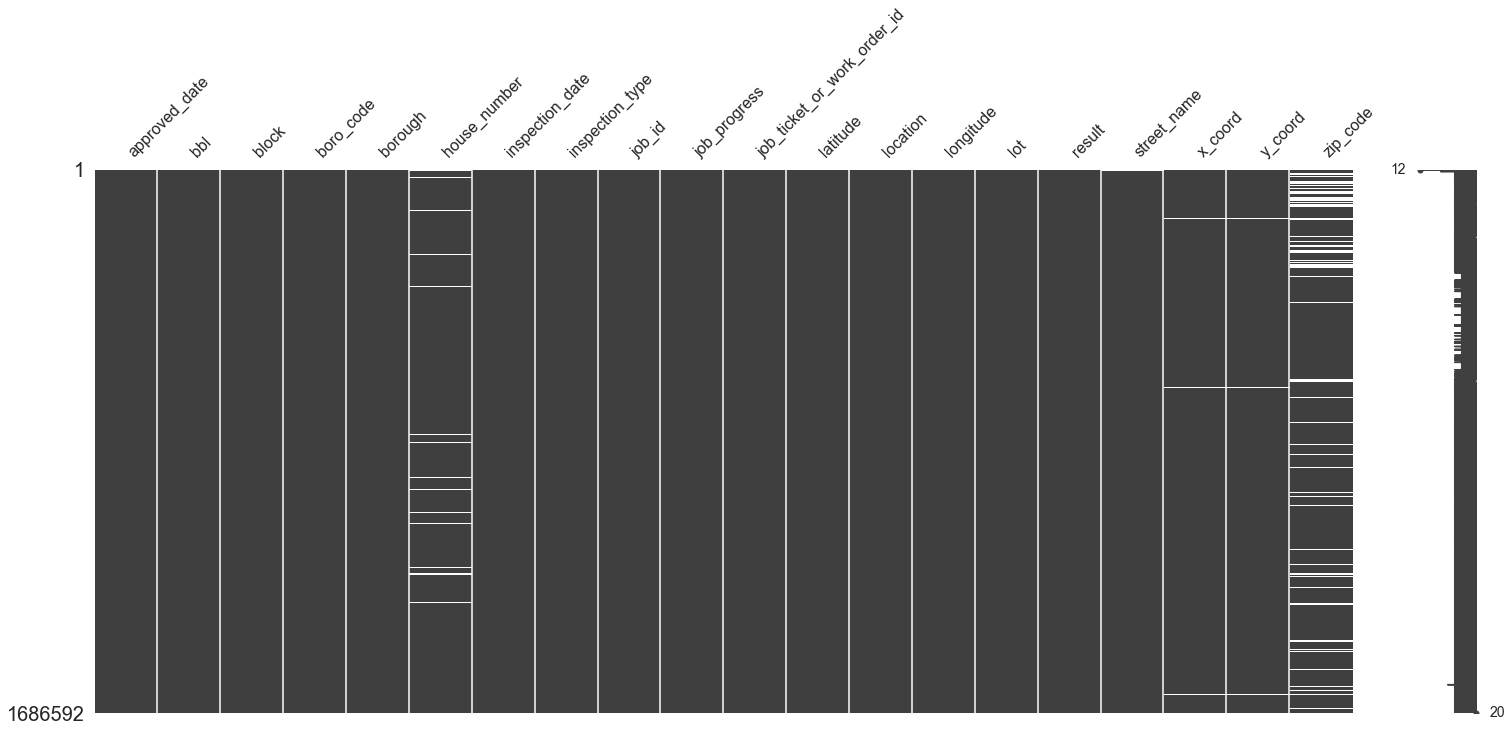

In [7]:
msno.matrix(df)

In [8]:
# Drop rows with null values
print(df.shape)
df.dropna(inplace=True)
print(df.shape)

(1686592, 20)
(1452001, 20)


In [9]:
reo_cols = ['inspection_type',
            'job_ticket_or_work_order_id',
            'job_id',
            'job_progress',
            'bbl',
            'boro_code',
            'block',
            'lot',
            'house_number',
            'street_name',
            'zip_code',
            'x_coord',
            'y_coord',
            'latitude',
            'longitude',
            'borough',
            'inspection_date',
            'result',
            'approved_date',
            'location']

df = df[reo_cols]
df.head(1)

,inspection_type,job_ticket_or_work_order_id,job_id,job_progress,bbl,boro_code,block,lot,house_number,street_name,zip_code,x_coord,y_coord,latitude,longitude,borough,inspection_date,result,approved_date,location
0,BAIT,345046,PO1438881,4,4099170043,4,09917,0043,88-01,181ST ST,11423,1044772,199101,40.712948338586,-73.781687097165,Queens,2017-08-04T09:20:18.000,Bait applied,2017-08-04T14:52:44.000,"{'type': 'Point', 'coordinates': [-73.78168709..."


In [10]:
# Change DataTypes and drop unnecessary columns
int_cols = ['job_ticket_or_work_order_id',
            'job_progress',
            'bbl',
            'boro_code',
            'block',
            'lot',
            'zip_code']

dt_cols = ['inspection_date',
           'approved_date']

flt_cols = ['latitude',
            'longitude']

str_cols = ['inspection_type',
            'job_id',
            'house_number',
            'street_name',
            'result']

drop_cols = ['x_coord',
             'y_coord',
             'location']

cat_cols = ['inspection_type', 'borough']

df[cat_cols] = df[cat_cols].astype('category')
df[str_cols] = df[str_cols].astype(str)
df[int_cols] = df[int_cols].astype(int)
df[flt_cols] = df[flt_cols].astype(float)
df[dt_cols] = df[dt_cols].apply(pd.to_datetime)
df.drop(columns=drop_cols,inplace=True)

In [11]:
# Remove rows with invalid bbl (Borough, Block, and Lot) values
print(df.shape)
df = df[df['bbl'].apply(lambda x: len(str(x)) > 9)]
print(df.shape)

(1452001, 17)
(1437316, 17)


In [12]:
# Remove invalid zip codes
print(df.shape)
df = df[df['zip_code'].apply(lambda x: len(str(x)) == 5)]
print(df.shape)

(1437316, 17)
(1437310, 17)


In [13]:
# df[df['house_number'].str.contains('88-01') == True].sort_values(by=['job_id', 'job_progress']).head(1)
# df.loc[df['job_id'] == 'PO983684'].sort_values(by='job_progress').head(1)
# df.loc[df['job_id'] == 'PO1475045'].sort_values(by='job_progress')
# df.loc[df['job_progress'] == 170]

In [14]:
# Create df of 'passed' & 'failed' target variables
df_passed = df.loc[(df['result'] == 'Passed Inspection') & (df['inspection_type'] == 'INITIAL')]
print(df_passed.shape)
df_failed = pd.concat([df, df_passed]).drop_duplicates(keep=False)
print(df_failed.shape)

(800542, 17)
(636768, 17)


In [15]:
# Dedup Failed dataset and set results = 'Failed Inspection'
df_failed = df_failed.loc[(df_failed['result'] != 'Passed Inspection') & (df_failed['job_progress'] == 1) & (df_failed['house_number'] != 'nan') & (df_failed['street_name'] != 'nan') & (df_failed['zip_code'] != 0)]
df_failed['result'] = 'Failed Inspection'
print(df_failed.shape)
df_failed.drop_duplicates(inplace=True)
print(df_failed.shape)
df_failed.head(1)

(235387, 17)
(235387, 17)


,inspection_type,job_ticket_or_work_order_id,job_id,job_progress,bbl,boro_code,block,lot,house_number,street_name,zip_code,latitude,longitude,borough,inspection_date,result,approved_date
1,INITIAL,1477376,PO1477376,1,3030820047,3,3082,47,71,WHITE ST,11206,40.706139,-73.935536,Brooklyn,2017-08-02 14:27:38,Failed Inspection,2017-08-04 09:20:05


In [16]:
# Dedup Failed dataset and set results = 'Failed Inspection'
df_failed = df_failed.loc[(df_failed['result'] != 'Passed Inspection') & (df_failed['job_progress'] == 1) & (df_failed['house_number'] != 'nan') & (df_failed['street_name'] != 'nan') & (df_failed['zip_code'] != 0)]
df_failed['result'] = 'Failed Inspection'

dedup_cols = ['bbl',
              'boro_code',
              'block',
              'lot',
              'house_number',
              'street_name',
              'zip_code']

# Before Count
print(df_failed.shape)
# After Count
print(df_failed.sort_values(by=dedup_cols).drop_duplicates(subset=dedup_cols).shape)
# Total Count Removed
print(df_failed.shape[0] - df_failed.sort_values(by=dedup_cols).drop_duplicates(subset=dedup_cols).shape[0])
# Commit Dedup
df_failed.sort_values(by=dedup_cols).drop_duplicates(subset=dedup_cols, inplace=True)

(235387, 17)
(108226, 17)
127161


In [17]:
### Dedup Passed DataFrame
# Before Count
print(df_passed.shape)
# After Count
print(df_passed.sort_values(by=dedup_cols).drop_duplicates(subset=dedup_cols).shape)
# Total Count Removed
print(df_passed.shape[0] - df_passed.sort_values(by=dedup_cols).drop_duplicates(subset=dedup_cols).shape[0])
# Commit Dedup
df_passed.sort_values(by=dedup_cols).drop_duplicates(subset=dedup_cols, inplace=True)

(800542, 17)
(217480, 17)
583062


In [18]:
# Exploratory queries to find dups
f_element_group_sizes = df_failed['bbl'].groupby(df_failed['bbl']).transform('size')
print(df_failed[f_element_group_sizes>1].shape)
p_element_group_sizes = df_passed['bbl'].groupby(df_passed['bbl']).transform('size')
print(df_passed[p_element_group_sizes>1].sort_values(by=['bbl','house_number']).shape)

(233268, 17)
(798277, 17)


In [19]:
# Combine 'Passed' and 'Failed' datasets
df = pd.concat([df_failed, df_passed], ignore_index=True)
df.drop_duplicates(subset=dedup_cols, inplace=True)

### Pickle orginal df due to Download API runtime

## Write to pickle file
df.to_pickle('df_pre.pkl')

## Read from pickle file
# df = pd.read_pickle('df_pre.pkl')

print('df Counts:')
print(df.shape)
print(df.loc[(df['result'] == 'Passed Inspection')].shape)
print(df.loc[(df['result'] == 'Failed Inspection')].shape)

df Counts:
(261445, 17)
(153219, 17)
(108226, 17)


In [20]:
### Memory Management: delete unused dfs

#delete when no longer needed
del df_passed
del df_failed

#collect residual garbage
gc.collect()

193

In [21]:
## add bb column which will be used later to append additional borough/block metrics for modeling
bb_mask = lambda x: str(x)[:6]
df['bb'] = df['bbl'].apply(bb_mask)
df['bb'] = df['bb'].astype(int)
df.head(1)

,inspection_type,job_ticket_or_work_order_id,job_id,job_progress,bbl,boro_code,block,lot,house_number,street_name,zip_code,latitude,longitude,borough,inspection_date,result,approved_date,bb
0,INITIAL,1477376,PO1477376,1,3030820047,3,3082,47,71,WHITE ST,11206,40.706139,-73.935536,Brooklyn,2017-08-02 14:27:38,Failed Inspection,2017-08-04 09:20:05,303082


Text(0.5, 1.0, 'Class Imbalance: Target Variable Counts by Borough')

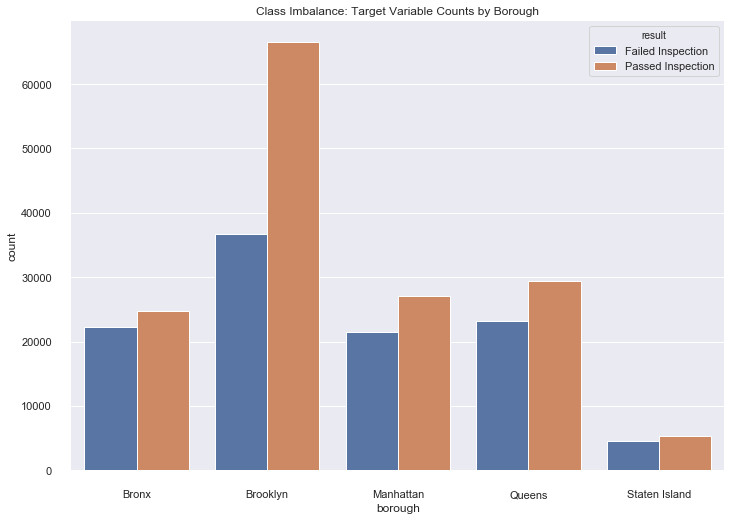

In [22]:
# Plot Data for EDA purposes
# set the background colour of the plot to white
sns.set(style="whitegrid", color_codes=True)

# setting the plot size for all plots
sns.set(rc={'figure.figsize':(11.7,8.27)})

# create a countplot
sns.countplot('borough',data=df,hue = 'result').set_title('Class Imbalance: Target Variable Counts by Borough')

# Remove the top and down margin
sns.despine(offset=10, trim=True)

# display the plotplt.show()

Target Variable
result
Failed Inspection    108226
Passed Inspection    153219
Name: result, dtype: int64


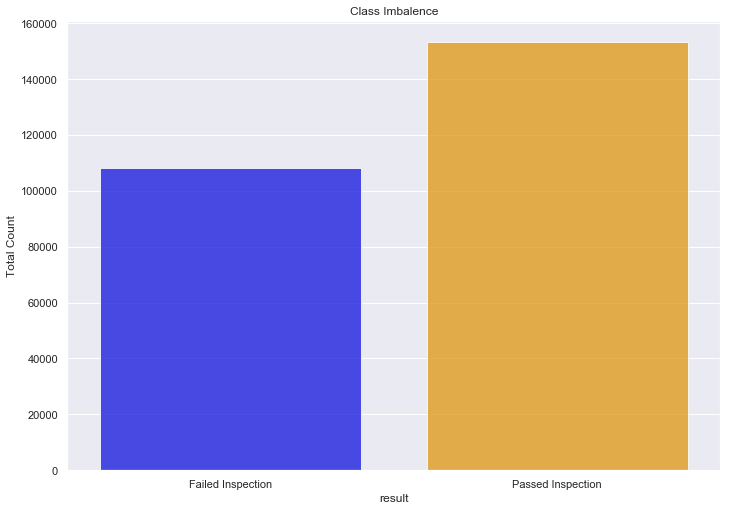

In [23]:
# target variable 'result' counts
print('Target Variable')
print(df.groupby(['result']).result.count())

# Target Variable Countplot
sns.set_style('darkgrid')
plt.figure(figsize = (11.7,8.27))
sns.countplot(df['result'], alpha =.80, palette= ['blue','orange'])
plt.title('Class Imbalence')
plt.ylabel('Total Count')
plt.show();

### Import 311 Service Requests

In [24]:
#### 311 Service Requests from 2010 to Present

# source = https://data.cityofnewyork.us/Social-Services/311-Service-Requests-from-2010-to-Present/erm2-nwe9
# Added constraints to API call to limit data retrieved
# code commented due to pickling after inital pull -> Data downloads via API ~ 10 mins
####
# start = time.time()
# client_311 = Socrata("data.cityofnewyork.us", None)
# results_311 = client_311.get("fhrw-4uyv", limit=3000000,order='created_date DESC', where='created_date > "2018-05-11"')
# df_311 = pd.DataFrame.from_records(results_311)
# end = time.time()
# print(end-start)
# print(df_311.shape)
# df_311.head(1)
####

### Pickle 311 records due to volume of records and download runtime

## Write to pickle file
# df_311.to_pickle('df_311.pkl')

## Read from pickle file
df_311 = pd.read_pickle('df_311.pkl')
print(df_311.shape)
df_311.head(1)

(2753543, 41)


,address_type,agency,agency_name,bbl,borough,bridge_highway_direction,bridge_highway_name,bridge_highway_segment,city,closed_date,community_board,complaint_type,created_date,cross_street_1,cross_street_2,descriptor,due_date,facility_type,incident_address,incident_zip,intersection_street_1,intersection_street_2,landmark,latitude,location,location_type,longitude,open_data_channel_type,park_borough,park_facility_name,resolution_action_updated_date,resolution_description,road_ramp,status,street_name,taxi_company_borough,taxi_pick_up_location,unique_key,vehicle_type,x_coordinate_state_plane,y_coordinate_state_plane
0,ADDRESS,DSNY,Department of Sanitation,4002640001,QUEENS,NaN,NaN,NaN,Long Island City,NaN,02 QUEENS,Request Large Bulky Item Collection,2019-05-11T02:41:00.000,ORCHARD STREET,QUEENS PLAZA SOUTH,Request Large Bulky Item Collection,NaN,N/A,28-10 JACKSON AVENUE,11101,NaN,NaN,NaN,40.74849081688869,"{'type': 'Point', 'coordinates': [-73.93855184...",Sidewalk,-73.93855184851218,PHONE,QUEENS,Unspecified,2019-05-24T00:00:00.000,The Department of Sanitation has sent this com...,NaN,Assigned,JACKSON AVENUE,NaN,NaN,42638175,NaN,1001276,211978


In [25]:
# Drop unnecessary columns
df311_dropcols = ['address_type',
                  'bridge_highway_direction',
                  'bridge_highway_name',
                  'bridge_highway_segment',
                  'closed_date',
                  'community_board',
                  'cross_street_1',
                  'cross_street_2',
                  'due_date',
                  'facility_type',
                  'intersection_street_1',
                  'intersection_street_2',
                  'landmark',
                  'open_data_channel_type',
                  'park_facility_name',
                  'road_ramp',
                  'taxi_company_borough',
                  'taxi_pick_up_location',
                  'vehicle_type']

print(df_311.shape)
df_311.drop(columns=df311_dropcols,inplace=True)
print(df_311.shape)

(2753543, 41)
(2753543, 22)


In [26]:
# Create Metric for # of 311 complaints per bbl
df_311_comp_counts = df_311.groupby('bbl')['complaint_type'].count().sort_values(ascending=False).reset_index()
df_311_comp_counts.rename({'complaint_type':'num_311_complaints_per_bbl'}, axis='columns',inplace=True)
print(df_311_comp_counts.shape)
int_cols = ['bbl', 'num_311_complaints_per_bbl']
df_311_comp_counts[int_cols] = df_311_comp_counts[int_cols].astype(int)
df_311_comp_counts.info()

(431907, 2)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 431907 entries, 0 to 431906
Data columns (total 2 columns):
bbl                           431907 non-null int64
num_311_complaints_per_bbl    431907 non-null int64
dtypes: int64(2)
memory usage: 6.6 MB


In [27]:
# Merge Metric for # of 311 complaints per bbl into df
df = df.merge(df_311_comp_counts, on='bbl',how='left')
df['num_311_complaints_per_bbl'].fillna(0, inplace=True)
print(df.shape)
df.tail(1)

(261445, 19)


,inspection_type,job_ticket_or_work_order_id,job_id,job_progress,bbl,boro_code,block,lot,house_number,street_name,zip_code,latitude,longitude,borough,inspection_date,result,approved_date,bb,num_311_complaints_per_bbl
261444,INITIAL,1752757,PO1752757,1,3062230010,3,5942,27,546,BAY RIDGE PARKWAY,11228,40.618703,-74.004809,Brooklyn,2018-07-09 14:39:03,Passed Inspection,2018-07-25 10:38:51,306223,0.0


In [28]:
### Memory Management: delete unused dfs

#delete when no longer needed
del df_311
del df_311_comp_counts

#collect residual garbage
gc.collect()

41

### Housing Maintenance Code Violations Metric

In [29]:
#### Housing Maintenance Code Violations

# source = https://data.cityofnewyork.us/Housing-Development/Housing-Maintenance-Code-Violations/wvxf-dwi5
# Added constraints to API call to limit data retrieved
# code commented due to pickling after inital pull -> Data downloads via API ~ 10 mins
####

# start = time.time()
# client_hmcv = Socrata("data.cityofnewyork.us", None)
# # results_hmcv = client_hmcv.get("b2iz-pps8", limit=5500000,order='inspectinodate DESC', where='inspectiondate > "2018-05-11"')
# results_hmcv = client_hmcv.get("b2iz-pps8", limit=5500000)
# df_hmcv = pd.DataFrame.from_records(results_hmcv)
# end = time.time()
# print(end-start)
# print(df_hmcv.shape)
# df_hmcv.head(1)
####

### Pickle HMCV records due to volume of records and download runtime

## Write to pickle file
# df_hmcv.to_pickle('df_hmcv.pkl')

## Read from pickle file
df_hmcv = pd.read_pickle('df_hmcv.pkl')
df_hmcv.head(1)

,apartment,approveddate,bbl,bin,block,boro,boroid,buildingid,censustract,certifieddate,class,communityboard,councildistrict,currentstatus,currentstatusdate,currentstatusid,highhousenumber,housenumber,inspectiondate,latitude,longitude,lot,lowhousenumber,newcertifybydate,newcorrectbydate,novdescription,novid,novissueddate,novtype,nta,ordernumber,originalcertifybydate,originalcorrectbydate,registrationid,story,streetcode,streetname,violationid,violationstatus,zip
0,NaN,2013-10-09T00:00:00.000,3046740064,3102071,4674,BROOKLYN,3,265980,870,NaN,B,17,41,VIOLATION CLOSED,2015-03-31T00:00:00.000,19,355,355,2013-10-08T00:00:00.000,40.653217,-73.932480,64,355,NaN,NaN,SECTION 27-2005 ADM CODE REPAIR THE BROKEN OR...,4705852,2013-10-10T00:00:00.000,Original,East Flatbush-Farragut,508,2013-11-28T00:00:00.000,2013-11-14T00:00:00.000,301467,2,36930,EAST 48 STREET,10000009,Close,11203


In [30]:
dfhmcv_rcols = ['apartment',
                'certifieddate',
                'class',
                'communityboard',
                'councildistrict',
                'newcertifybydate',
                'newcorrectbydate',
                'novdescription',
                'novid',
                'novissueddate',
                'novtype',
                'ordernumber',
                'registrationid',
                'story',
                'streetcode',
                'streetname']

df_hmcv.drop(columns=dfhmcv_rcols,inplace=True)

print(df_hmcv.shape)
df_hmcv.tail().transpose()

(5312628, 24)


,5312623,5312624,5312625,5312626,5312627
approveddate,2013-08-22T00:00:00.000,2013-08-22T00:00:00.000,2013-08-22T00:00:00.000,2013-09-30T00:00:00.000,2013-10-02T00:00:00.000
bbl,3039710033,3039710033,3039710033,3013740033,1003540020
bin,3391414,3391414,3391414,3036609,1004313
block,3971,3971,3971,1374,354
boro,BROOKLYN,BROOKLYN,BROOKLYN,BROOKLYN,MANHATTAN
boroid,3,3,3,3,1
buildingid,853494,853494,853494,351600,805177
censustract,1168,1168,1168,347,3001
currentstatus,VIOLATION CLOSED,VIOLATION CLOSED,VIOLATION CLOSED,VIOLATION DISMISSED,VIOLATION CLOSED
currentstatusdate,2015-11-24T00:00:00.000,2015-11-24T00:00:00.000,2016-08-07T00:00:00.000,2019-04-18T00:00:00.000,2019-04-30T00:00:00.000


In [31]:
# Create Metric for # of hmcv violations per bbl
df_hmcv_counts = df_hmcv.groupby('bbl')['violationid'].count().sort_values(ascending=False).reset_index()
df_hmcv_counts.rename({'violationid':'num_hmcv_per_bbl'}, axis='columns',inplace=True)
print(df_hmcv_counts.shape)
int_cols = ['bbl', 'num_hmcv_per_bbl']
df_hmcv_counts[int_cols] = df_hmcv_counts[int_cols].astype(int)
df_hmcv_counts.info()

(184267, 2)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 184267 entries, 0 to 184266
Data columns (total 2 columns):
bbl                 184267 non-null int64
num_hmcv_per_bbl    184267 non-null int64
dtypes: int64(2)
memory usage: 2.8 MB


In [32]:
# Merge Metric for # of hmcv violations per bbl into df
df = df.merge(df_hmcv_counts, on='bbl',how='left')
df['num_hmcv_per_bbl'].fillna(0, inplace=True)
print(df.shape)
df.tail(1)

(261445, 20)


,inspection_type,job_ticket_or_work_order_id,job_id,job_progress,bbl,boro_code,block,lot,house_number,street_name,zip_code,latitude,longitude,borough,inspection_date,result,approved_date,bb,num_311_complaints_per_bbl,num_hmcv_per_bbl
261444,INITIAL,1752757,PO1752757,1,3062230010,3,5942,27,546,BAY RIDGE PARKWAY,11228,40.618703,-74.004809,Brooklyn,2018-07-09 14:39:03,Passed Inspection,2018-07-25 10:38:51,306223,0.0,3.0


In [33]:
### Memory Management: delete unused dfs

#delete when no longer needed
del df_hmcv
del df_hmcv_counts

#collect residual garbage
gc.collect()

89

### Energy and Water Data Disclosure for Local Law Metric

In [34]:
#### Energy and Water Data Disclosure for Local Law 84 2017 (Data for Calendar Year 2016)
# source = https://data.cityofnewyork.us/Environment/Energy-and-Water-Data-Disclosure-for-Local-Law-84-/8u86-bviy
####

# start = time.time()
# client_ewdd = Socrata("data.cityofnewyork.us", None)
# results_ewdd = client_ewdd.get("8u86-bviy", limit=5500000)
# df_ewdd = pd.DataFrame.from_records(results_ewdd)
# end = time.time()
# print(end-start)
# print(df_ewdd.shape)
# df_ewdd.head(1)
####

### Pickle EWDD records

## Write to pickle file
# df_ewdd.to_pickle('df_ewdd.pkl')

## Read from pickle file
df_ewdd = pd.read_pickle('df_ewdd.pkl')
df_ewdd.head(1)

,_2nd_largest_property_use_gross_floor_area_ft,_2nd_largest_property_use_type,_3rd_largest_property_use_type,_3rd_largest_property_use_type_gross_floor_area_ft,address_1_self_reported,address_2,bbl_10_digits,borough,census_tract,community_board,council_district,diesel_2_use_kbtu,direct_ghg_emissions_metric_tons_co2e,district_steam_use_kbtu,dof_benchmarking_submission_status,dof_gross_floor_area,electricity_use_grid_purchase_kbtu,energy_star_score,fuel_oil_1_use_kbtu,fuel_oil_2_use_kbtu,fuel_oil_4_use_kbtu,fuel_oil_5_6_use_kbtu,indirect_ghg_emissions_metric_tons_co2e,largest_property_use_type,largest_property_use_type_gross_floor_area_ft,latitude,list_of_all_property_use_types_at_property,longitude,metered_areas_energy,metered_areas_water,natural_gas_use_kbtu,nta,number_of_buildings_self_reported,nyc_borough_block_and_lot_bbl_self_reported,nyc_building_identification_number_bin,occupancy,order,parent_property_id,parent_property_name,postal_code,primary_property_type_self_selected,property_gfa_self_reported_ft,property_id,property_name,release_date,site_eui_kbtu_ft,source_eui_kbtu_ft,street_name,street_number,total_ghg_emissions_metric_tons_co2e,water_intensity_all_water_sources_gal_ft,water_required,water_use_all_water_sources_kgal,weather_normalized_site_electricity_intensity_kwh_ft,weather_normalized_site_electricity_kwh,weather_normalized_site_eui_kbtu_ft,weather_normalized_site_natural_gas_intensity_therms_ft,weather_normalized_site_natural_gas_use_therms,weather_normalized_source_eui_kbtu_ft,year_built
0,Not Available,Not Available,Not Available,Not Available,201/205 East 42nd st.,Not Available,1013160001,Manhattan,88,6,4,Not Available,0,5.15506751E7,In Compliance,289356,38139374.2,Not Available,Not Available,Not Available,Not Available,Not Available,6962.2,Office,293447,40.750791,Office,-73.973963,Whole Building,Not Available,Not Available,Turtle Bay-East Midtown ...,2,1013160001,1037549,100,1,13286,201/205,10017,Office,762051,13286,201/205,2017-05-01T17:32:03.000,305.6,619.4,3 AVENUE,675,6962.2,Not Available,No,Not Available,37.8,1.10827705E7,303.1,Not Available,Not Available,614.2,1963


In [35]:
# Replace target string with nan
df_ewdd.replace('Not Available', np.nan, inplace=True)

# Rename target column
df_ewdd.rename({'bbl_10_digits':'bbl'}, axis='columns',inplace=True)

In [36]:
# create new groupby df for ewdd
dfgb_ewdd = df_ewdd[['bbl','property_gfa_self_reported_ft']]

# Add 'bb' column to merge target metric

dfgb_ewdd['bb'] = dfgb_ewdd['bbl'].apply(bb_mask)
dfgb_ewdd.head(1)

/Users/utaveras/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,bbl,property_gfa_self_reported_ft,bb
0,1013160001,762051,101316


In [37]:
# Check for invalid values
print(dfgb_ewdd[dfgb_ewdd['bbl'].isnull()].shape)
print(dfgb_ewdd[dfgb_ewdd['property_gfa_self_reported_ft']==0].shape)
print(dfgb_ewdd[dfgb_ewdd['property_gfa_self_reported_ft'].isnull()].shape)

# Change datatypes
dfgb_ewdd['bb'] = pd.to_numeric(dfgb_ewdd['bb'], errors='coerce')
dfgb_ewdd = dfgb_ewdd.dropna(subset=['bb'])
dfgb_ewdd['bb'] = dfgb_ewdd['bb'].astype(int)
dfgb_ewdd['property_gfa_self_reported_ft'] = dfgb_ewdd['property_gfa_self_reported_ft'].astype(float)

# rename target metric for merging
dfgb_ewdd = dfgb_ewdd.groupby('bb')['property_gfa_self_reported_ft'].mean().reset_index()
dfgb_ewdd.rename({'property_gfa_self_reported_ft':'mean_property_gfa_self_reported_ft_per_bb'}, axis='columns',inplace=True)

print(dfgb_ewdd.info())


(51, 3)
(0, 3)
(0, 3)


/Users/utaveras/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5075 entries, 0 to 5074
Data columns (total 2 columns):
bb                                           5075 non-null int64
mean_property_gfa_self_reported_ft_per_bb    5075 non-null float64
dtypes: float64(1), int64(1)
memory usage: 79.4 KB
None


In [38]:
# Merge Metric for mean Self-reported total gross square footage (ft2) of the property per bbl into df
df = df.merge(dfgb_ewdd, on='bb',how='left')
# df['mean_property_gfa_self_reported_ft'].fillna(0, inplace=True)
print(df.shape)
print(df[df['mean_property_gfa_self_reported_ft_per_bb'].isnull()].shape)
df.tail(1)

(261445, 21)
(175883, 21)


,inspection_type,job_ticket_or_work_order_id,job_id,job_progress,bbl,boro_code,block,lot,house_number,street_name,zip_code,latitude,longitude,borough,inspection_date,result,approved_date,bb,num_311_complaints_per_bbl,num_hmcv_per_bbl,mean_property_gfa_self_reported_ft_per_bb
261444,INITIAL,1752757,PO1752757,1,3062230010,3,5942,27,546,BAY RIDGE PARKWAY,11228,40.618703,-74.004809,Brooklyn,2018-07-09 14:39:03,Passed Inspection,2018-07-25 10:38:51,306223,0.0,3.0,NaN


In [39]:
# Replace missing property gfa values with mean of boro
df.mean_property_gfa_self_reported_ft_per_bb = df.groupby('boro_code')['mean_property_gfa_self_reported_ft_per_bb'].apply(lambda x: x.fillna(x.mean()))
df.mean_property_gfa_self_reported_ft_per_bb = df.mean_property_gfa_self_reported_ft_per_bb.fillna(df.mean_property_gfa_self_reported_ft_per_bb.mean())
print(df[df['mean_property_gfa_self_reported_ft_per_bb'].isnull()].shape)
df.tail(1)

(0, 21)


,inspection_type,job_ticket_or_work_order_id,job_id,job_progress,bbl,boro_code,block,lot,house_number,street_name,zip_code,latitude,longitude,borough,inspection_date,result,approved_date,bb,num_311_complaints_per_bbl,num_hmcv_per_bbl,mean_property_gfa_self_reported_ft_per_bb
261444,INITIAL,1752757,PO1752757,1,3062230010,3,5942,27,546,BAY RIDGE PARKWAY,11228,40.618703,-74.004809,Brooklyn,2018-07-09 14:39:03,Passed Inspection,2018-07-25 10:38:51,306223,0.0,3.0,114726.08914


In [40]:
### Memory Management: delete unused dfs

#delete when no longer needed
del df_ewdd
del dfgb_ewdd

#collect residual garbage
gc.collect()

116

### Bureau of Fire Prevention - Active Violation Orders

In [41]:
#### Bureau of Fire Prevention - Active Violation Orders
# source = https://data.cityofnewyork.us/Public-Safety/Bureau-of-Fire-Prevention-Active-Violation-Orders/bi53-yph3
####

# start = time.time()
# client_bfpv = Socrata("data.cityofnewyork.us", None)
# results_bfpv = client_bfpv.get("bi53-yph3", limit=5500000)
# df_bfpv = pd.DataFrame.from_records(results_bfpv)
# end = time.time()
# print(end-start)
# print(df_bfpv.shape)
# df_bfpv.head(1)
####

### Pickle EWDD records

## Write to pickle file
# df_bfpv.to_pickle('df_bfpv.pkl')

## Read from pickle file
df_bfpv = pd.read_pickle('df_bfpv.pkl')

print(df_bfpv.shape)
df_bfpv.head(1)

(52406, 21)


,acct_num,acct_owner,action,bbl,bin,borough,census_tract,cent_latitude,cent_longitude,citycouncildistrict,communitydistrict,nta,number,prem_addr,street,vio_date,vio_id,vio_law_desc,vio_law_num,violation_num,zipcode
0,28209732,MTA NYC TRANSIT,OPEN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,1 SO FERRY STATION,SO FERRY STATION,2017-04-20T00:00:00.000,1,PROVIDE/POST VALVES SIGNS SPK SY,SPK 40,E494287,NaN


In [42]:
# Drop nan bbl rows
print(df_bfpv.shape)
df_bfpv.dropna(subset=['bbl'],inplace=True)
df_bfpv.info()

(52406, 21)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 50166 entries, 56 to 52405
Data columns (total 21 columns):
acct_num               50166 non-null object
acct_owner             50166 non-null object
action                 50166 non-null object
bbl                    50166 non-null object
bin                    50166 non-null object
borough                50166 non-null object
census_tract           50145 non-null object
cent_latitude          50166 non-null object
cent_longitude         50166 non-null object
citycouncildistrict    50153 non-null object
communitydistrict      50153 non-null object
nta                    50145 non-null object
number                 50166 non-null object
prem_addr              50166 non-null object
street                 50166 non-null object
vio_date               50166 non-null object
vio_id                 50166 non-null object
vio_law_desc           48507 non-null object
vio_law_num            50166 non-null object
violation_num          

In [43]:
# create new groupby df for Bureau of Fire Prevention Violations (bfpv)
dfgb_bfpv = df_bfpv[['bbl','vio_id']]

# Add 'bb' column to merge target metric
dfgb_bfpv['bb'] = dfgb_bfpv['bbl'].apply(bb_mask)
dfgb_bfpv.head(1)

/Users/utaveras/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


,bbl,vio_id,bb
56,1000020002,57,100002


In [44]:
# Change datatypes
# dfgb_bfpv['bb'] = pd.to_numeric(dfgb_bfpv['bb'], errors='coerce')
# dfgb_bfpv = dfgb_bfpv.dropna(subset=['bb'])
bfpv_intcols = ['bb','vio_id']
dfgb_bfpv[bfpv_intcols] = dfgb_bfpv[bfpv_intcols].astype(int)

# rename target metric for merging
dfgb_bfpv = dfgb_bfpv.groupby('bb')['vio_id'].count().reset_index()
dfgb_bfpv.rename({'vio_id':'avg_num_dfpv_ids_per_bb'}, axis='columns',inplace=True)

print(dfgb_bfpv.info())
dfgb_bfpv.tail()

/Users/utaveras/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3391: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[k1] = value[k2]


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8418 entries, 0 to 8417
Data columns (total 2 columns):
bb                         8418 non-null int64
avg_num_dfpv_ids_per_bb    8418 non-null int64
dtypes: int64(2)
memory usage: 131.6 KB
None


,bb,avg_num_dfpv_ids_per_bb
8413,508014,1
8414,508020,1
8415,508040,1
8416,508043,2
8417,508048,1


In [45]:
# Merge Metric for number of Bureau of Fire Prevention Violations per bb into df
df = df.merge(dfgb_bfpv, on='bb',how='left')
print(df.shape)
print(df[df['avg_num_dfpv_ids_per_bb'].isnull()].shape)
df.tail()

(261445, 22)
(128680, 22)


,inspection_type,job_ticket_or_work_order_id,job_id,job_progress,bbl,boro_code,block,lot,house_number,street_name,zip_code,latitude,longitude,borough,inspection_date,result,approved_date,bb,num_311_complaints_per_bbl,num_hmcv_per_bbl,mean_property_gfa_self_reported_ft_per_bb,avg_num_dfpv_ids_per_bb
261440,INITIAL,1731169,PO1731169,1,3011430070,3,1144,68,197,SAINT MARKS AVENUE,11217,40.679389,-73.972610,Brooklyn,2018-06-29 09:40:54,Passed Inspection,2018-07-02 09:18:21,301143,0.0,0.0,114726.08914,2.0
261441,INITIAL,452256,PO452256,1,3041790035,3,4471,43,793,DREW STREET,11208,40.681799,-73.863969,Brooklyn,2012-04-18 13:39:29,Passed Inspection,2012-04-20 10:47:44,304179,0.0,0.0,114726.08914,NaN
261442,INITIAL,472368,PO472368,1,3014770023,3,4018,17,2428,PITKIN AVENUE,11233,40.668447,-73.921503,Brooklyn,2012-05-17 15:30:50,Passed Inspection,2012-05-21 14:51:14,301477,0.0,8.0,114726.08914,11.0
261443,INITIAL,489969,PO489969,1,3034020028,3,3398,63,249,WEIRFIELD STREET,11221,40.688487,-73.913658,Brooklyn,2012-06-12 10:36:29,Passed Inspection,2012-06-13 13:23:27,303402,1.0,15.0,114726.08914,NaN
261444,INITIAL,1752757,PO1752757,1,3062230010,3,5942,27,546,BAY RIDGE PARKWAY,11228,40.618703,-74.004809,Brooklyn,2018-07-09 14:39:03,Passed Inspection,2018-07-25 10:38:51,306223,0.0,3.0,114726.08914,NaN


In [46]:
# Replace missing number of Bureau of Fire Prevention Violations per bb with mean of boro
df.avg_num_dfpv_ids_per_bb = df.groupby('boro_code')['avg_num_dfpv_ids_per_bb'].apply(lambda x: x.fillna(x.mean()))
df.avg_num_dfpv_ids_per_bb = df.avg_num_dfpv_ids_per_bb.fillna(df.avg_num_dfpv_ids_per_bb.mean())
print(df[df['avg_num_dfpv_ids_per_bb'].isnull()].shape)
df.tail()

(0, 22)


,inspection_type,job_ticket_or_work_order_id,job_id,job_progress,bbl,boro_code,block,lot,house_number,street_name,zip_code,latitude,longitude,borough,inspection_date,result,approved_date,bb,num_311_complaints_per_bbl,num_hmcv_per_bbl,mean_property_gfa_self_reported_ft_per_bb,avg_num_dfpv_ids_per_bb
261440,INITIAL,1731169,PO1731169,1,3011430070,3,1144,68,197,SAINT MARKS AVENUE,11217,40.679389,-73.972610,Brooklyn,2018-06-29 09:40:54,Passed Inspection,2018-07-02 09:18:21,301143,0.0,0.0,114726.08914,2.000000
261441,INITIAL,452256,PO452256,1,3041790035,3,4471,43,793,DREW STREET,11208,40.681799,-73.863969,Brooklyn,2012-04-18 13:39:29,Passed Inspection,2012-04-20 10:47:44,304179,0.0,0.0,114726.08914,4.577743
261442,INITIAL,472368,PO472368,1,3014770023,3,4018,17,2428,PITKIN AVENUE,11233,40.668447,-73.921503,Brooklyn,2012-05-17 15:30:50,Passed Inspection,2012-05-21 14:51:14,301477,0.0,8.0,114726.08914,11.000000
261443,INITIAL,489969,PO489969,1,3034020028,3,3398,63,249,WEIRFIELD STREET,11221,40.688487,-73.913658,Brooklyn,2012-06-12 10:36:29,Passed Inspection,2012-06-13 13:23:27,303402,1.0,15.0,114726.08914,4.577743
261444,INITIAL,1752757,PO1752757,1,3062230010,3,5942,27,546,BAY RIDGE PARKWAY,11228,40.618703,-74.004809,Brooklyn,2018-07-09 14:39:03,Passed Inspection,2018-07-25 10:38:51,306223,0.0,3.0,114726.08914,4.577743


In [47]:
### Memory Management: delete unused dfs

#delete when no longer needed
del df_bfpv
del dfgb_bfpv

#collect residual garbage
gc.collect()

34

### HPD Fee Charges

In [48]:
# Department of Housing Preservation and Development Fee Charges
# source = https://data.cityofnewyork.us/Housing-Development/Fee-Charges/cp6j-7bjj
####

# start = time.time()
# client_hpdfc = Socrata("data.cityofnewyork.us", None)
# results_hpdfc = client_hpdfc.get("cp6j-7bjj", limit=5500000)
# df_hpdfc = pd.DataFrame.from_records(results_hpdfc)
# end = time.time()
# print(end-start)
# print(df_hpdfc.shape)
# df_hpdfc.head(1)
####

# Pickle HPD Fee Charge records

# Write to pickle file
# df_hpdfc.to_pickle('df_hpdfc.pkl')

# Read from pickle file
df_hpdfc = pd.read_pickle('df_hpdfc.pkl')

print(df_hpdfc.shape)
df_hpdfc.head(1)


(40876, 19)


,block,boro,boroid,buildingid,dofaccounttype,doftransferdate,feeamount,feeid,feeissueddate,feesourceid,feesourcetype,feesourcetypeid,feetype,feetypeid,housenumber,lifecycle,lot,streetname,zip
0,1370,BROOKLYN,3,183598,236,2008-06-20T00:00:00.000,2000.00,441,2008-05-23T00:00:00.000,30305,PROJECT BLDG,51,Initial Re-inspection Fee,1,227,Building,14,ALBANY AVENUE,11213


In [49]:
# Add bb attribute for future merging
df_hpdfc['bb'] = df_hpdfc['boroid'] + df_hpdfc['block'].str.zfill(5)

# Rename target column
df_hpdfc.rename({'feeamount':'hpd_feeamount'}, axis='columns',inplace=True)

# create new groupby df for HPD Fees
dfgb_hpdfc = df_hpdfc[['bb','hpd_feeamount']]

df_hpdfc.tail().transpose()

,40871,40872,40873,40874,40875
block,9807,15567,4512,1454,5172
boro,QUEENS,QUEENS,BRONX,BROOKLYN,BROOKLYN
boroid,4,4,2,3,3
buildingid,576291,653207,118934,374615,256026
dofaccounttype,243,243,243,243,243
doftransferdate,NaN,NaN,NaN,NaN,NaN
hpd_feeamount,200.00,200.00,200.00,200.00,200.00
feeid,914497,914498,914499,914500,914501
feeissueddate,2019-04-30T00:00:00.000,2019-04-30T00:00:00.000,2019-04-30T00:00:00.000,2019-04-30T00:00:00.000,2019-04-30T00:00:00.000
feesourceid,136552,136553,136554,136555,136556


In [50]:
# Check for invalid values
print(dfgb_hpdfc[dfgb_hpdfc['bb'].isnull()].shape)
print(dfgb_hpdfc[dfgb_hpdfc['hpd_feeamount']==0].shape)
print(dfgb_hpdfc[dfgb_hpdfc['hpd_feeamount'].isnull()].shape)

# Change datatypes
dfgb_hpdfc['bb'] = pd.to_numeric(dfgb_hpdfc['bb'], errors='coerce')
dfgb_hpdfc = dfgb_hpdfc.dropna(subset=['bb'])
dfgb_hpdfc['bb'] = dfgb_hpdfc['bb'].astype(int)
dfgb_hpdfc['hpd_feeamount'] = dfgb_hpdfc['hpd_feeamount'].astype(float)

# rename target metric for merging
dfgb_hpdfc = dfgb_hpdfc.groupby('bb')['hpd_feeamount'].mean().reset_index()
dfgb_hpdfc.rename({'hpd_feeamount':'mean_hpd_feeamount_per_bb'}, axis='columns',inplace=True)

print(dfgb_hpdfc.info())

(0, 2)
(0, 2)
(0, 2)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4532 entries, 0 to 4531
Data columns (total 2 columns):
bb                           4532 non-null int64
mean_hpd_feeamount_per_bb    4532 non-null float64
dtypes: float64(1), int64(1)
memory usage: 70.9 KB
None


/Users/utaveras/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


In [51]:
# Merge Metric for mean HPD Fee Charges per bb into df
df = df.merge(dfgb_hpdfc, on='bb',how='left')
# df['mean_hpd_feeamount'].fillna(0, inplace=True)
print(df.shape)
print(df[df['mean_hpd_feeamount_per_bb'].isnull()].shape)
df.tail()

(261445, 23)
(161801, 23)


,inspection_type,job_ticket_or_work_order_id,job_id,job_progress,bbl,boro_code,block,lot,house_number,street_name,zip_code,latitude,longitude,borough,inspection_date,result,approved_date,bb,num_311_complaints_per_bbl,num_hmcv_per_bbl,mean_property_gfa_self_reported_ft_per_bb,avg_num_dfpv_ids_per_bb,mean_hpd_feeamount_per_bb
261440,INITIAL,1731169,PO1731169,1,3011430070,3,1144,68,197,SAINT MARKS AVENUE,11217,40.679389,-73.972610,Brooklyn,2018-06-29 09:40:54,Passed Inspection,2018-07-02 09:18:21,301143,0.0,0.0,114726.08914,2.000000,200.0
261441,INITIAL,452256,PO452256,1,3041790035,3,4471,43,793,DREW STREET,11208,40.681799,-73.863969,Brooklyn,2012-04-18 13:39:29,Passed Inspection,2012-04-20 10:47:44,304179,0.0,0.0,114726.08914,4.577743,NaN
261442,INITIAL,472368,PO472368,1,3014770023,3,4018,17,2428,PITKIN AVENUE,11233,40.668447,-73.921503,Brooklyn,2012-05-17 15:30:50,Passed Inspection,2012-05-21 14:51:14,301477,0.0,8.0,114726.08914,11.000000,NaN
261443,INITIAL,489969,PO489969,1,3034020028,3,3398,63,249,WEIRFIELD STREET,11221,40.688487,-73.913658,Brooklyn,2012-06-12 10:36:29,Passed Inspection,2012-06-13 13:23:27,303402,1.0,15.0,114726.08914,4.577743,200.0
261444,INITIAL,1752757,PO1752757,1,3062230010,3,5942,27,546,BAY RIDGE PARKWAY,11228,40.618703,-74.004809,Brooklyn,2018-07-09 14:39:03,Passed Inspection,2018-07-25 10:38:51,306223,0.0,3.0,114726.08914,4.577743,NaN


In [52]:
# Replace missing mean HPD Fee Charges per bb with mean of boro
df.mean_hpd_feeamount_per_bb = df.groupby('boro_code')['mean_hpd_feeamount_per_bb'].apply(lambda x: x.fillna(x.mean()))
df.mean_hpd_feeamount_per_bb = df.mean_hpd_feeamount_per_bb.fillna(df.mean_hpd_feeamount_per_bb.mean())
print(df[df['mean_hpd_feeamount_per_bb'].isnull()].shape)
df.tail()

(0, 23)


,inspection_type,job_ticket_or_work_order_id,job_id,job_progress,bbl,boro_code,block,lot,house_number,street_name,zip_code,latitude,longitude,borough,inspection_date,result,approved_date,bb,num_311_complaints_per_bbl,num_hmcv_per_bbl,mean_property_gfa_self_reported_ft_per_bb,avg_num_dfpv_ids_per_bb,mean_hpd_feeamount_per_bb
261440,INITIAL,1731169,PO1731169,1,3011430070,3,1144,68,197,SAINT MARKS AVENUE,11217,40.679389,-73.972610,Brooklyn,2018-06-29 09:40:54,Passed Inspection,2018-07-02 09:18:21,301143,0.0,0.0,114726.08914,2.000000,200.000000
261441,INITIAL,452256,PO452256,1,3041790035,3,4471,43,793,DREW STREET,11208,40.681799,-73.863969,Brooklyn,2012-04-18 13:39:29,Passed Inspection,2012-04-20 10:47:44,304179,0.0,0.0,114726.08914,4.577743,457.149937
261442,INITIAL,472368,PO472368,1,3014770023,3,4018,17,2428,PITKIN AVENUE,11233,40.668447,-73.921503,Brooklyn,2012-05-17 15:30:50,Passed Inspection,2012-05-21 14:51:14,301477,0.0,8.0,114726.08914,11.000000,457.149937
261443,INITIAL,489969,PO489969,1,3034020028,3,3398,63,249,WEIRFIELD STREET,11221,40.688487,-73.913658,Brooklyn,2012-06-12 10:36:29,Passed Inspection,2012-06-13 13:23:27,303402,1.0,15.0,114726.08914,4.577743,200.000000
261444,INITIAL,1752757,PO1752757,1,3062230010,3,5942,27,546,BAY RIDGE PARKWAY,11228,40.618703,-74.004809,Brooklyn,2018-07-09 14:39:03,Passed Inspection,2018-07-25 10:38:51,306223,0.0,3.0,114726.08914,4.577743,457.149937


In [53]:
#delete when no longer needed
del df_hpdfc
del dfgb_hpdfc

#collect residual garbage
gc.collect()

116

### DYCD Demographic Statistics By Zip Code

In [54]:
# Department of Youth and Community Development (DYCD)
# Demographic Statistics By Zip Code
# source = https://data.cityofnewyork.us/City-Government/Demographic-Statistics-By-Zip-Code/kku6-nxdu
####

# start = time.time()
# client_dycddemo = Socrata("data.cityofnewyork.us", None)
# results_dycddemo = client_dycddemo.get("kku6-nxdu", limit=5500000)
# df_dycddemo = pd.DataFrame.from_records(results_dycddemo)
# end = time.time()
# print(end-start)
# print(df_dycddemo.shape)
# df_dycddemo.head(1)
####

# Pickle EWDD records

# Write to pickle file
# df_dycddemo.to_pickle('df_dycddemo.pkl')

# Read from pickle file
df_dycddemo = pd.read_pickle('df_dycddemo.pkl')

# print(df_dycddemo.shape)
# df_dycddemo.head(1).transpose()

In [55]:
# Replace target value with nan
df_dycddemo.replace('0', np.nan, inplace=True)

# Rename target column
df_dycddemo.rename({'jurisdiction_name': 'zip_code'},
                   axis='columns', inplace=True)

df_dycddemo.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 236 entries, 0 to 235
Data columns (total 46 columns):
count_american_indian                  4 non-null object
count_asian_non_hispanic               41 non-null object
count_black_non_hispanic               56 non-null object
count_citizen_status_total             105 non-null object
count_citizen_status_unknown           0 non-null float64
count_ethnicity_total                  105 non-null object
count_ethnicity_unknown                17 non-null object
count_female                           97 non-null object
count_gender_total                     105 non-null object
count_gender_unknown                   0 non-null float64
count_hispanic_latino                  54 non-null object
count_male                             94 non-null object
count_nreceives_public_assistance      101 non-null object
count_other_citizen_status             9 non-null object
count_other_ethnicity                  54 non-null object
count_pacific_islander 

In [56]:
# Assess Nan Values
print('DYCD Demographic Statistics By Zip Code Missing Values:\n')
missing_values_table(df_dycddemo)
missing_values_table(df_dycddemo)[missing_values_table(df_dycddemo).Pct_of_Total_Values < 65].index.tolist()

DYCD Demographic Statistics By Zip Code Missing Values:

Your selected dataframe has 46 columns.
There are 45 columns that have missing values.


,Missing_Values,Pct_of_Total_Values
count_gender_unknown,236,100.0
percent_citizen_status_unknown,236,100.0
percent_public_assistance_unknown,236,100.0
count_citizen_status_unknown,236,100.0
count_public_assistance_unknown,236,100.0
percent_gender_unknown,236,100.0
count_american_indian,232,98.3
count_pacific_islander,232,98.3
percent_american_indian,232,98.3
percent_pacific_islander,232,98.3


Your selected dataframe has 46 columns.
There are 45 columns that have missing values.
Your selected dataframe has 46 columns.
There are 45 columns that have missing values.


['count_receives_public_assistance',
 'percent_receives_public_assistance',
 'count_male',
 'percent_male',
 'count_female',
 'percent_female',
 'count_nreceives_public_assistance',
 'percent_nreceives_public_assistance',
 'percent_us_citizen',
 'count_us_citizen',
 'count_participants',
 'percent_citizen_status_total',
 'percent_gender_total',
 'count_gender_total',
 'count_public_assistance_total',
 'count_ethnicity_total',
 'percent_public_assistance_total',
 'count_citizen_status_total',
 'percent_ethnicity_total']

In [57]:
# create new groupby df for DYCD Data

dfdycd_cols = ['count_receives_public_assistance',
               'percent_receives_public_assistance',
               'count_male',
               'percent_male',
               'count_female',
               'percent_female',
               'count_nreceives_public_assistance',
               'percent_nreceives_public_assistance',
               'percent_us_citizen',
               'count_us_citizen',
               'count_participants',
               'percent_citizen_status_total',
               'percent_gender_total',
               'count_gender_total',
               'count_public_assistance_total',
               'count_ethnicity_total',
               'percent_public_assistance_total',
               'count_citizen_status_total',
               'percent_ethnicity_total']

dfdycd_cols = [x for x in dfdycd_cols if 'percent' in x and '_total' not in x]
dfdycd_cols.append('zip_code')
dfgb_dycddemo = df_dycddemo[dfdycd_cols]
dfdycd_cols.pop()
dfdycd_cols
dfgb_dycddemo.tail().transpose()

'zip_code'

['percent_receives_public_assistance',
 'percent_male',
 'percent_female',
 'percent_nreceives_public_assistance',
 'percent_us_citizen']

,231,232,233,234,235
percent_receives_public_assistance,0.42,0.26,0.41,NaN,NaN
percent_male,0.53,0.58,0.88,NaN,NaN
percent_female,0.47,0.42,0.12,NaN,NaN
percent_nreceives_public_assistance,0.58,0.74,0.59,NaN,NaN
percent_us_citizen,1,1,1,NaN,NaN
zip_code,12788,12789,13731,16091,20459


In [58]:
# Check for invalid values
print(dfgb_dycddemo[dfgb_dycddemo['zip_code'].isnull()].shape)
print(dfgb_dycddemo[dfgb_dycddemo[dfdycd_cols] == 0].shape)
print(dfgb_dycddemo[dfgb_dycddemo[dfdycd_cols].isnull()].shape)

# Change datatypes
dfgb_dycddemo['zip_code'] = pd.to_numeric(dfgb_dycddemo['zip_code'], errors='coerce')
dfgb_dycddemo = dfgb_dycddemo.dropna(subset=['zip_code'])
dfgb_dycddemo['zip_code'] = dfgb_dycddemo['zip_code'].astype(int)
dfgb_dycddemo[dfdycd_cols] = dfgb_dycddemo[dfdycd_cols].astype(float)

# Drop Nans
dfgb_dycddemo.dropna(inplace=True)
dfgb_dycddemo.drop_duplicates(inplace=True)

# rename columns for merging
old_cols = [x for x in dfdycd_cols]
new_cols = ['dycd_' + x + '_per_zip_code' for x in dfdycd_cols]
dfgb_dycddemo.rename(columns=dict(zip(old_cols, new_cols)), inplace=True)

dfgb_dycddemo.info()

(0, 6)
(236, 6)
(236, 6)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 75 entries, 0 to 233
Data columns (total 6 columns):
dycd_percent_receives_public_assistance_per_zip_code     75 non-null float64
dycd_percent_male_per_zip_code                           75 non-null float64
dycd_percent_female_per_zip_code                         75 non-null float64
dycd_percent_nreceives_public_assistance_per_zip_code    75 non-null float64
dycd_percent_us_citizen_per_zip_code                     75 non-null float64
zip_code                                                 75 non-null int64
dtypes: float64(5), int64(1)
memory usage: 4.1 KB


/Users/utaveras/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


In [59]:
# Merge DYCD Demographic Metrics per Zip Code into df
df = df.merge(dfgb_dycddemo, on='zip_code', how='left')
print(df.shape)
print(df.loc[df.columns.str.contains(pat='per_zip_code') == np.nan].shape)
df.tail()

(261445, 28)
(0, 28)


,inspection_type,job_ticket_or_work_order_id,job_id,job_progress,bbl,boro_code,block,lot,house_number,street_name,zip_code,latitude,longitude,borough,inspection_date,result,approved_date,bb,num_311_complaints_per_bbl,num_hmcv_per_bbl,mean_property_gfa_self_reported_ft_per_bb,avg_num_dfpv_ids_per_bb,mean_hpd_feeamount_per_bb,dycd_percent_receives_public_assistance_per_zip_code,dycd_percent_male_per_zip_code,dycd_percent_female_per_zip_code,dycd_percent_nreceives_public_assistance_per_zip_code,dycd_percent_us_citizen_per_zip_code
261440,INITIAL,1731169,PO1731169,1,3011430070,3,1144,68,197,SAINT MARKS AVENUE,11217,40.679389,-73.972610,Brooklyn,2018-06-29 09:40:54,Passed Inspection,2018-07-02 09:18:21,301143,0.0,0.0,114726.08914,2.000000,200.000000,NaN,NaN,NaN,NaN,NaN
261441,INITIAL,452256,PO452256,1,3041790035,3,4471,43,793,DREW STREET,11208,40.681799,-73.863969,Brooklyn,2012-04-18 13:39:29,Passed Inspection,2012-04-20 10:47:44,304179,0.0,0.0,114726.08914,4.577743,457.149937,NaN,NaN,NaN,NaN,NaN
261442,INITIAL,472368,PO472368,1,3014770023,3,4018,17,2428,PITKIN AVENUE,11233,40.668447,-73.921503,Brooklyn,2012-05-17 15:30:50,Passed Inspection,2012-05-21 14:51:14,301477,0.0,8.0,114726.08914,11.000000,457.149937,0.36,0.57,0.43,0.64,1.0
261443,INITIAL,489969,PO489969,1,3034020028,3,3398,63,249,WEIRFIELD STREET,11221,40.688487,-73.913658,Brooklyn,2012-06-12 10:36:29,Passed Inspection,2012-06-13 13:23:27,303402,1.0,15.0,114726.08914,4.577743,200.000000,NaN,NaN,NaN,NaN,NaN
261444,INITIAL,1752757,PO1752757,1,3062230010,3,5942,27,546,BAY RIDGE PARKWAY,11228,40.618703,-74.004809,Brooklyn,2018-07-09 14:39:03,Passed Inspection,2018-07-25 10:38:51,306223,0.0,3.0,114726.08914,4.577743,457.149937,NaN,NaN,NaN,NaN,NaN


In [60]:
# Replace missing DYCD Demographic Metrics values with ascending subgroup means
dycb_gbcols = new_cols
df[dycb_gbcols] = df.groupby('bb')[dycb_gbcols].transform(lambda x: x.fillna(x.mean()))
df[dycb_gbcols] = df.groupby('zip_code')[dycb_gbcols].transform(lambda x: x.fillna(x.mean()))
df[dycb_gbcols] = df.groupby('boro_code')[dycb_gbcols].transform(lambda x: x.fillna(x.mean()))
df[dycb_gbcols] = df[dycb_gbcols].fillna((df[dycb_gbcols].mean()))

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 261445 entries, 0 to 261444
Data columns (total 28 columns):
inspection_type                                          261445 non-null object
job_ticket_or_work_order_id                              261445 non-null int64
job_id                                                   261445 non-null object
job_progress                                             261445 non-null int64
bbl                                                      261445 non-null int64
boro_code                                                261445 non-null int64
block                                                    261445 non-null int64
lot                                                      261445 non-null int64
house_number                                             261445 non-null object
street_name                                              261445 non-null object
zip_code                                                 261445 non-null int64
latitude        

In [61]:
### Pickle df_post due to Download API runtime

# Save Dictionary of columns and Dtype for Colab setup
df_attr = df.dtypes.apply(lambda x: x.name).to_dict()
df_attr

## Write to pickle file
df.to_pickle('df_post.pkl')
df.to_csv('df_post.csv')

#### The following is only for use during initial load into Google Colab ###
df.to_pickle('df_onload.pkl')

## Read from pickle file
# df = pd.read_pickle('df_post.pkl')

{'inspection_type': 'object',
 'job_ticket_or_work_order_id': 'int64',
 'job_id': 'object',
 'job_progress': 'int64',
 'bbl': 'int64',
 'boro_code': 'int64',
 'block': 'int64',
 'lot': 'int64',
 'house_number': 'object',
 'street_name': 'object',
 'zip_code': 'int64',
 'latitude': 'float64',
 'longitude': 'float64',
 'borough': 'category',
 'inspection_date': 'datetime64[ns]',
 'result': 'object',
 'approved_date': 'datetime64[ns]',
 'bb': 'int64',
 'num_311_complaints_per_bbl': 'float64',
 'num_hmcv_per_bbl': 'float64',
 'mean_property_gfa_self_reported_ft_per_bb': 'float64',
 'avg_num_dfpv_ids_per_bb': 'float64',
 'mean_hpd_feeamount_per_bb': 'float64',
 'dycd_percent_receives_public_assistance_per_zip_code': 'float64',
 'dycd_percent_male_per_zip_code': 'float64',
 'dycd_percent_female_per_zip_code': 'float64',
 'dycd_percent_nreceives_public_assistance_per_zip_code': 'float64',
 'dycd_percent_us_citizen_per_zip_code': 'float64'}

In [62]:
# Memory Management: delete unused dfs

# delete when no longer needed
del df_dycddemo
del dfgb_dycddemo

# collect residual garbage
gc.collect()

152

In [63]:
### Sanity Check for dfs in-memory ###

%whos DataFrame

Variable   Type         Data/Info
---------------------------------
df         DataFrame           inspection_type  j<...>261445 rows x 28 columns]


### EDA on base df before modeling

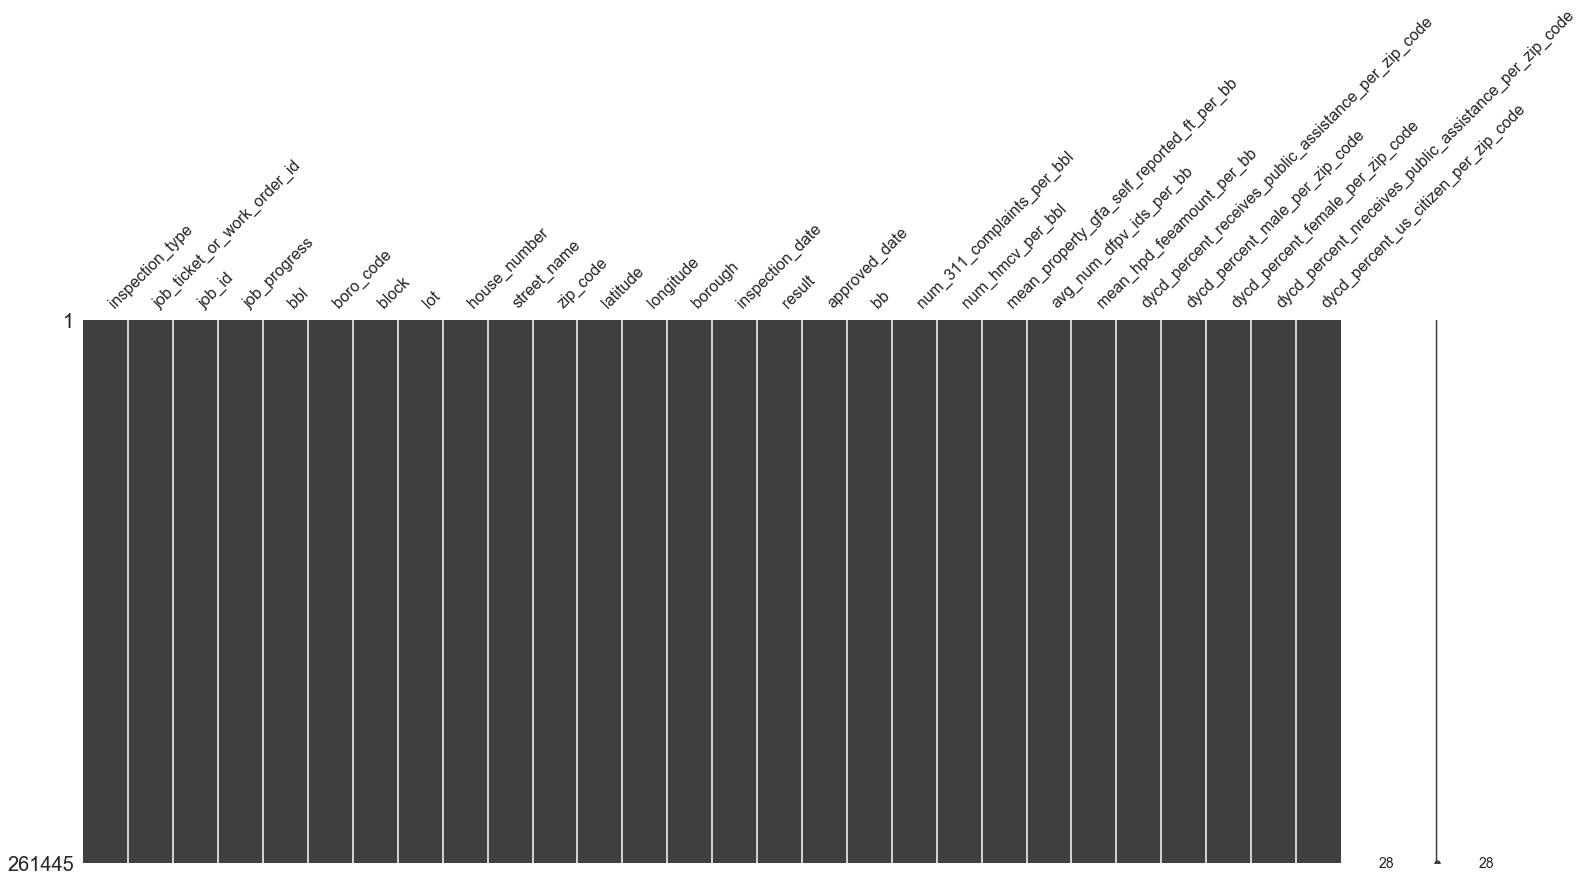

In [64]:
msno.matrix(df)

In [65]:
# Create Profile Report & Export to HTML

profile = pp.ProfileReport(df)
# profile.to_file('RodentModelEDA_ProfileReport.html',check_correlation=False)
profile.to_file('RodentModelEDA_ProfileReport.html')
profile

Number of variables,28
Number of observations,261445
Total Missing (%),0.0%
Total size in memory,56.1 MiB
Average record size in memory,225.0 B
Numeric,17
Categorical,5
Boolean,1
Date,2
Text (Unique),1
Rejected,2


In [66]:
# Create dictionary for boro_code encoding

gb = df[['boro_code','borough']].sort_values(by='boro_code')
gb.drop_duplicates(inplace=True)
borocode_mappings = gb.set_index('boro_code')['borough'].to_dict()
borocode_mappings

# Target Variable Mapping -> failed = 0 | pass = 1

{1: 'Manhattan', 2: 'Bronx', 3: 'Brooklyn', 4: 'Queens', 5: 'Staten Island'}

In [67]:
df['result_encoded'] = df['result'].map({'Failed Inspection': 0, 'Passed Inspection' : 1})
df[['result', 'result_encoded']].nunique()
df = df.drop(columns='result')
print(df.shape)
df.tail(1)

result            2
result_encoded    2
dtype: int64

(261445, 28)


,inspection_type,job_ticket_or_work_order_id,job_id,job_progress,bbl,boro_code,block,lot,house_number,street_name,zip_code,latitude,longitude,borough,inspection_date,approved_date,bb,num_311_complaints_per_bbl,num_hmcv_per_bbl,mean_property_gfa_self_reported_ft_per_bb,avg_num_dfpv_ids_per_bb,mean_hpd_feeamount_per_bb,dycd_percent_receives_public_assistance_per_zip_code,dycd_percent_male_per_zip_code,dycd_percent_female_per_zip_code,dycd_percent_nreceives_public_assistance_per_zip_code,dycd_percent_us_citizen_per_zip_code,result_encoded
261444,INITIAL,1752757,PO1752757,1,3062230010,3,5942,27,546,BAY RIDGE PARKWAY,11228,40.618703,-74.004809,Brooklyn,2018-07-09 14:39:03,2018-07-25 10:38:51,306223,0.0,3.0,114726.08914,4.577743,457.149937,0.52,0.15,0.85,0.48,0.99,1


latitude                                                -0.059414
num_hmcv_per_bbl                                        -0.051005
num_311_complaints_per_bbl                              -0.039914
dycd_percent_male_per_zip_code                          -0.035922
dycd_percent_receives_public_assistance_per_zip_code    -0.006747
block                                                   -0.005911
mean_hpd_feeamount_per_bb                               -0.004409
longitude                                               -0.002338
job_progress                                             0.001644
mean_property_gfa_self_reported_ft_per_bb                0.002565
dycd_percent_nreceives_public_assistance_per_zip_code    0.006804
avg_num_dfpv_ids_per_bb                                  0.015672
lot                                                      0.019812
bb                                                       0.022125
bbl                                                      0.022125
boro_code 

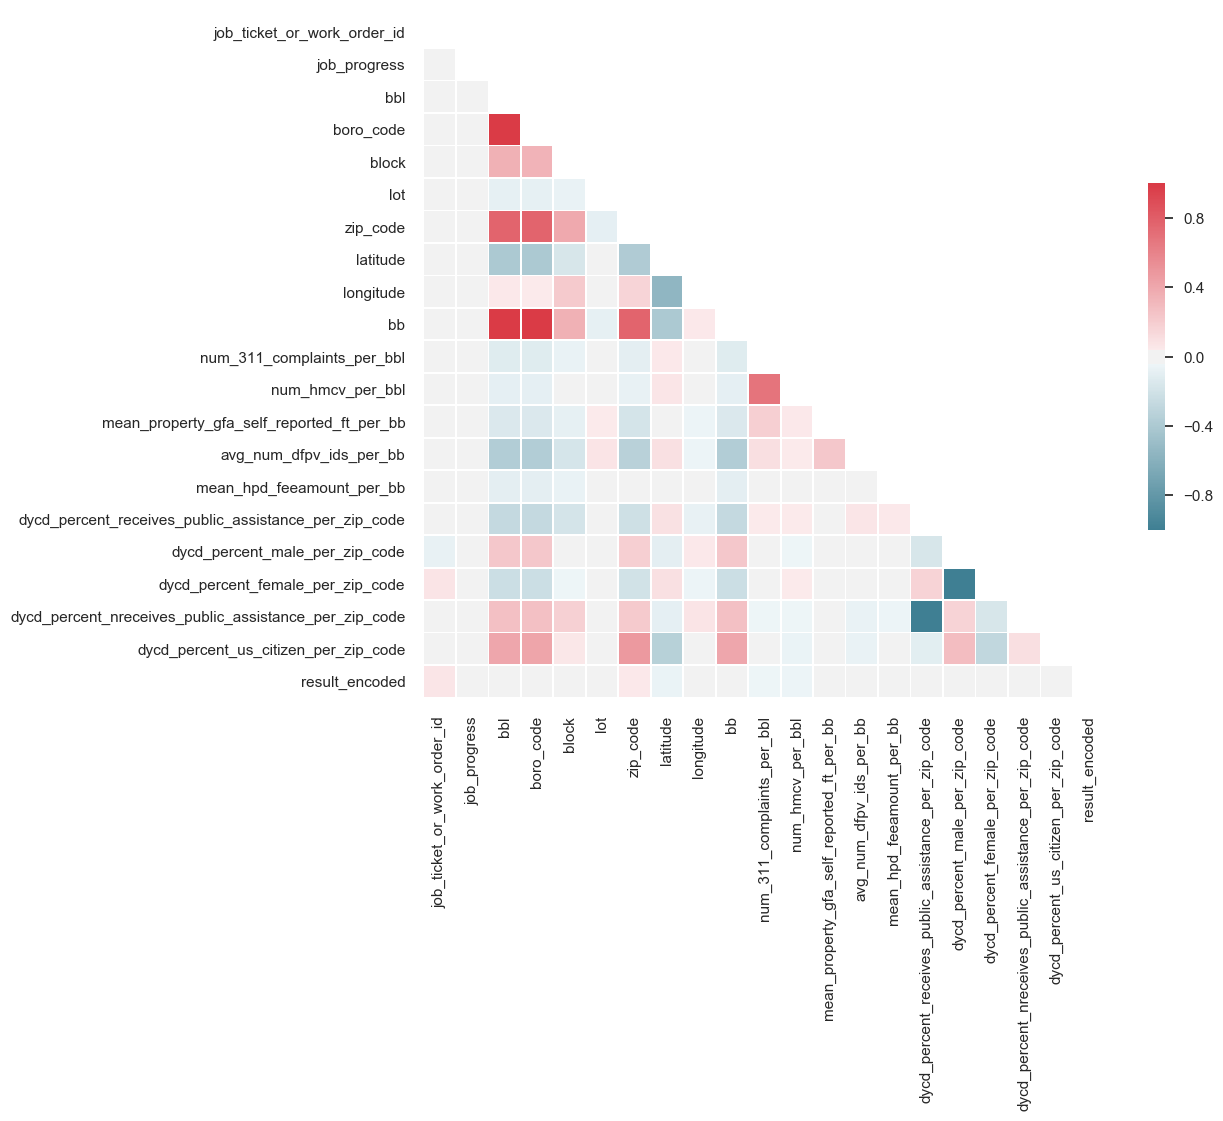

In [68]:
# Preprocessing Correlation Matrix
correlations_data = df.corr()['result_encoded'].sort_values()
correlations_data

sns.set(style="white")

# Compute the correlation matrix
corr = df.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
# sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
#             square=True, linewidths=.5, cbar_kws={"shrink": .5})
sns.heatmap(corr, mask=mask, cmap=cmap, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [69]:
# Correlation with output variable
# Output = no correlations

cor_target = abs(corr['result_encoded'])
#Selecting highly correlated features
relevant_features = cor_target[cor_target>0.5]
print('List of Features w/correlation > 0.5 to target variable: ')
print(relevant_features)

List of Features w/correlation > 0.5 to target variable: 
result_encoded    1.0
Name: result_encoded, dtype: float64


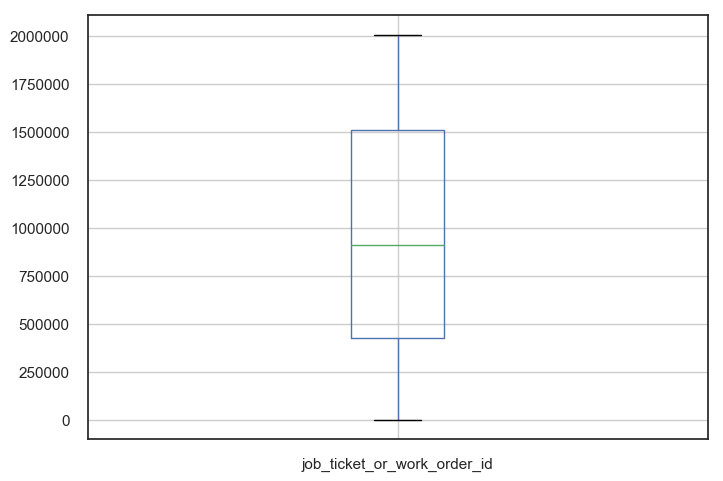

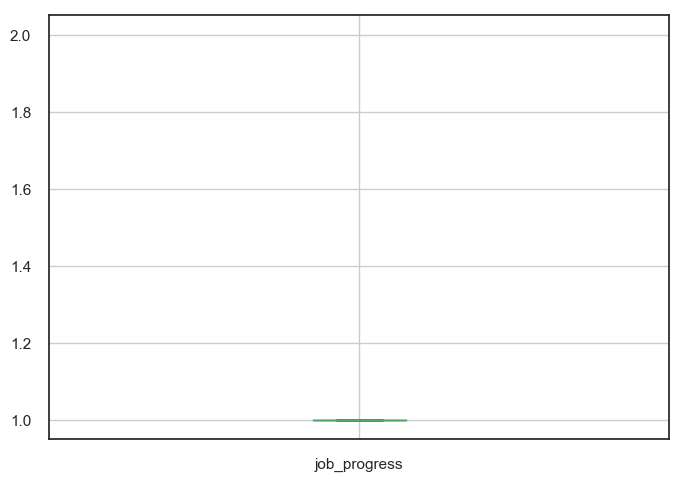

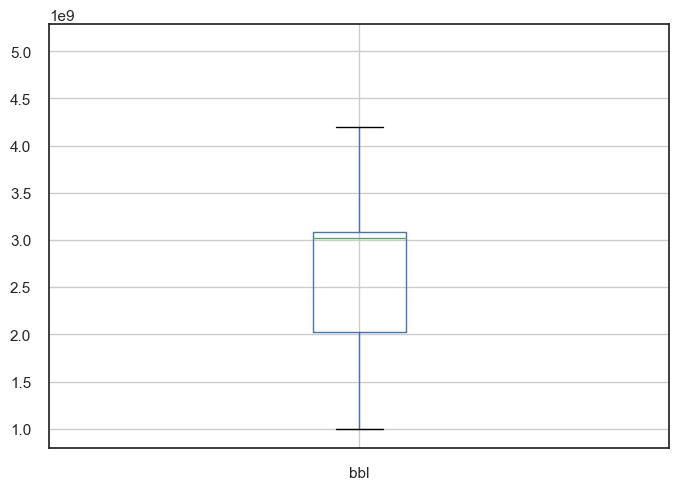

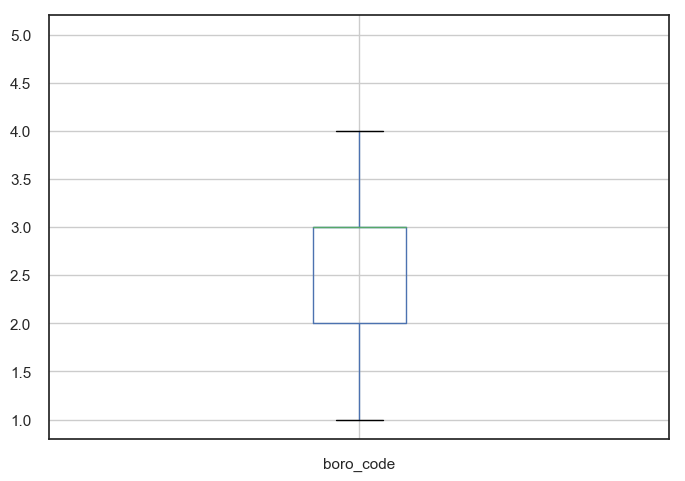

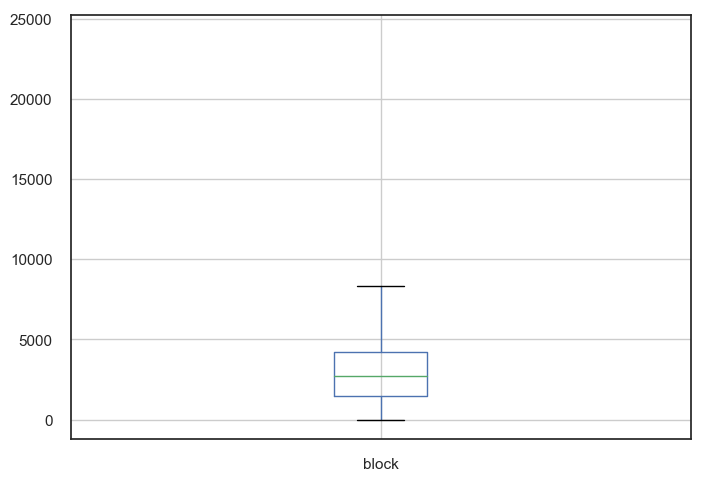

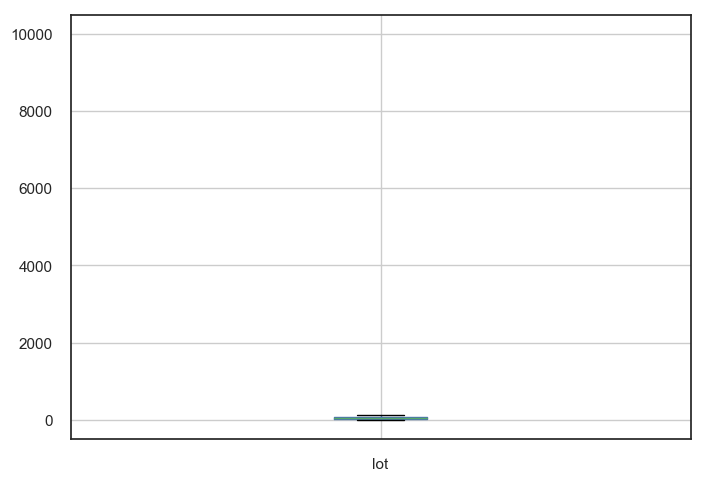

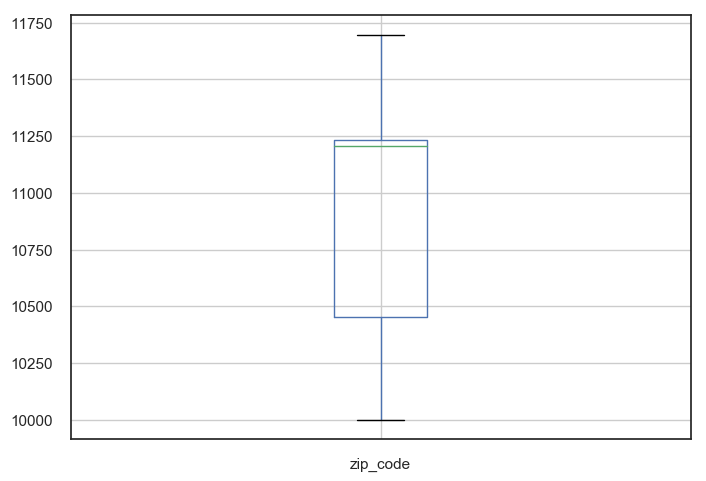

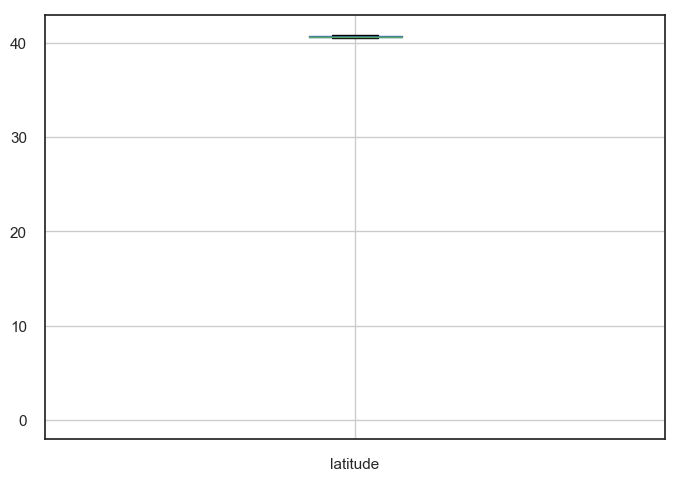

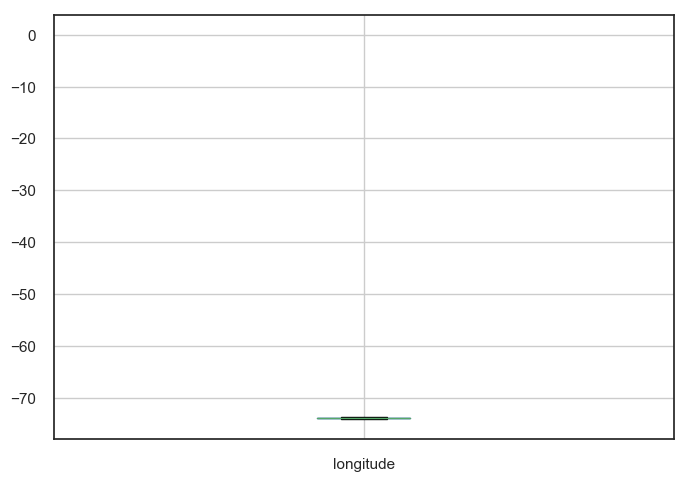

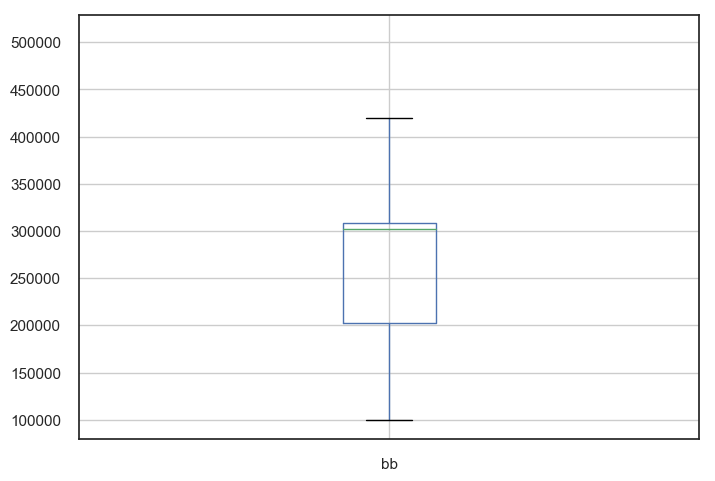

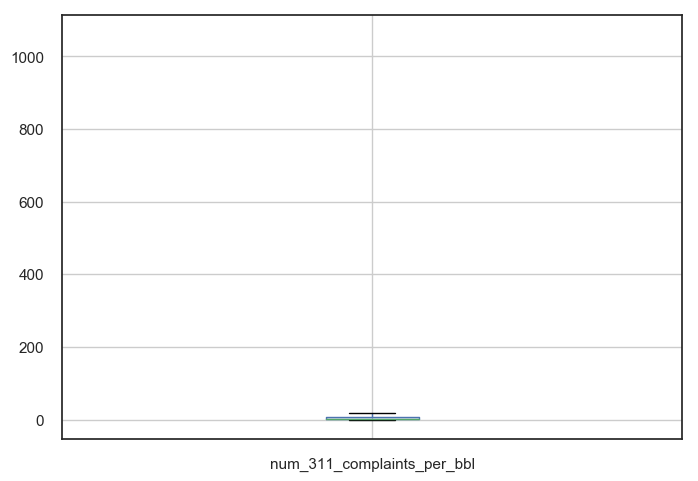

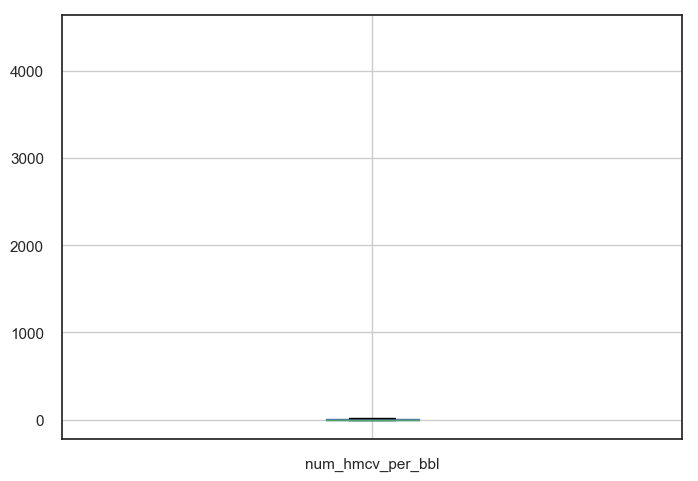

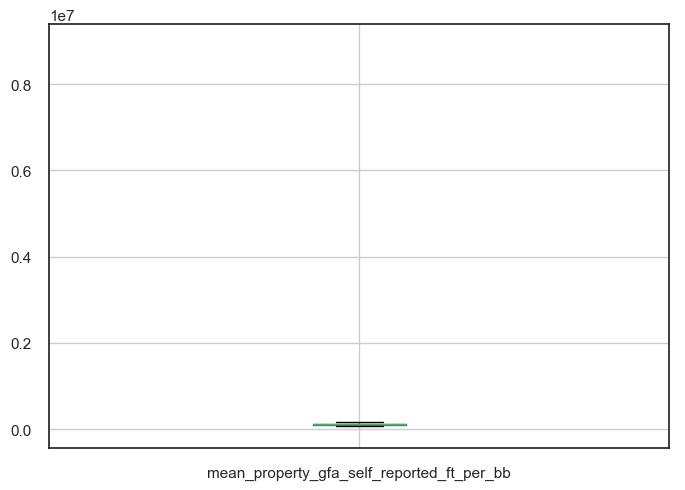

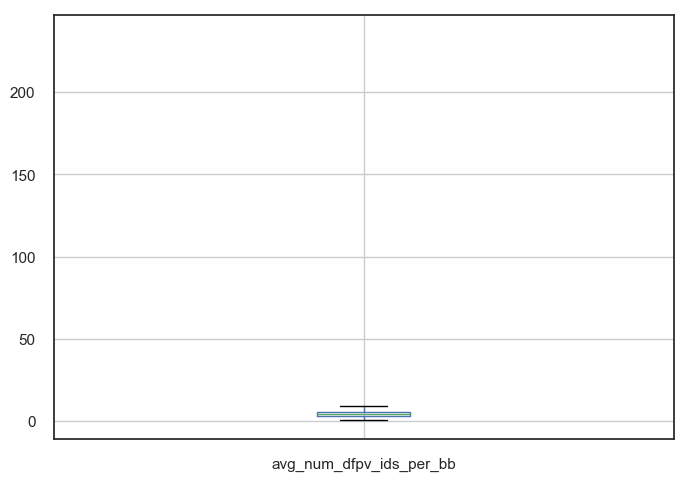

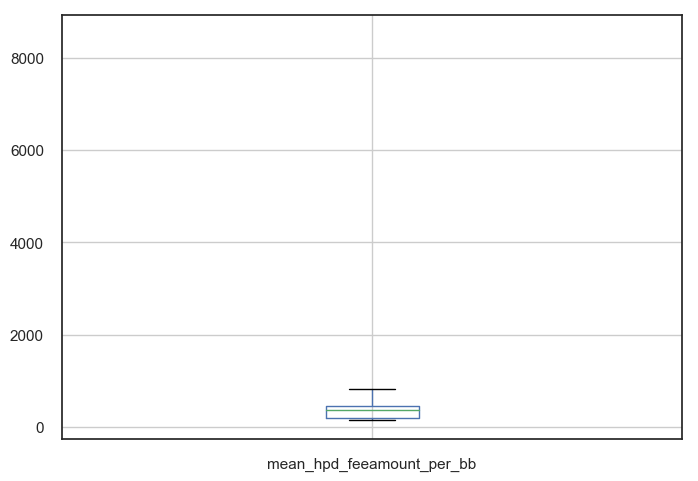

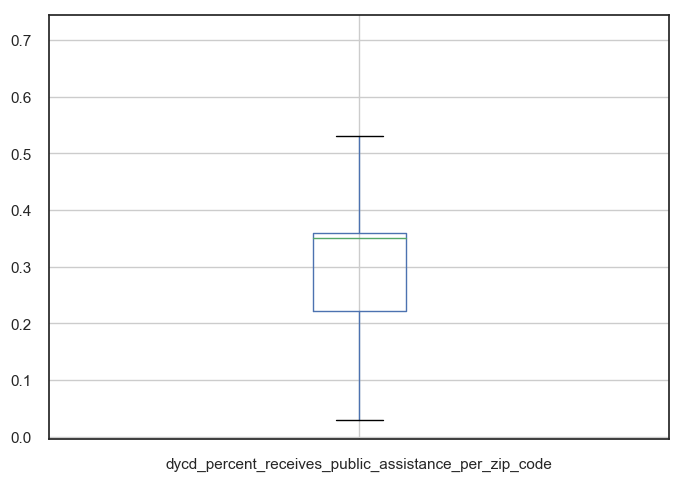

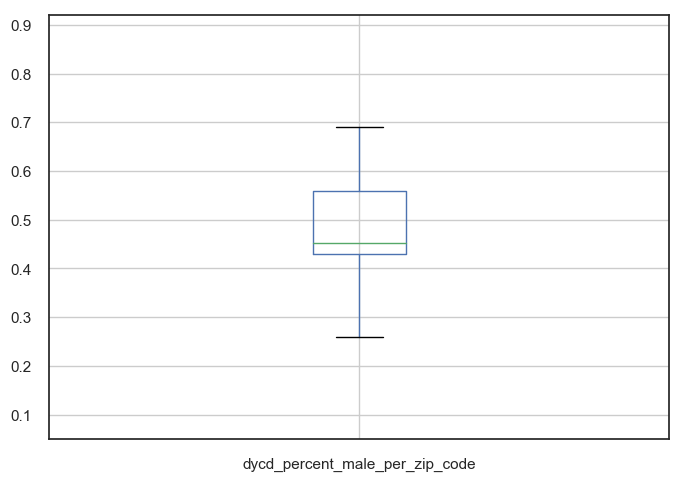

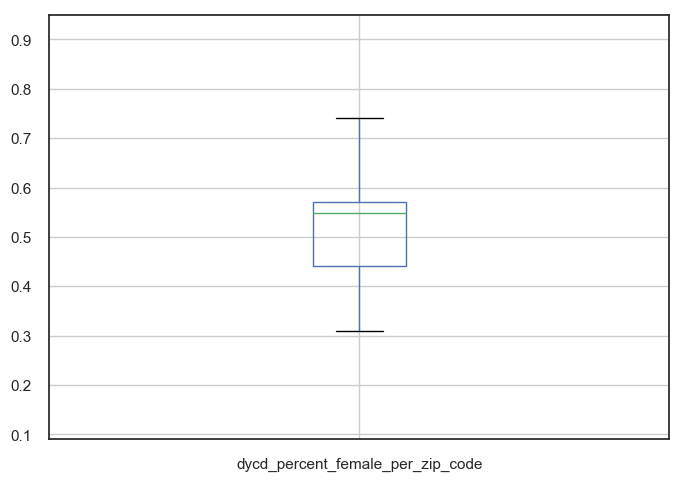

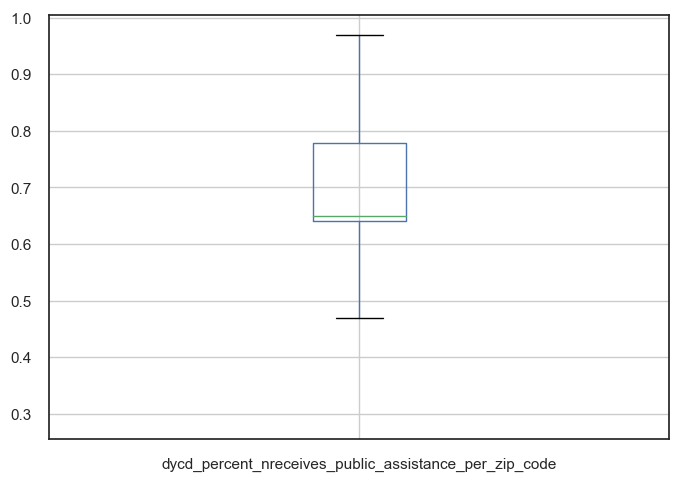

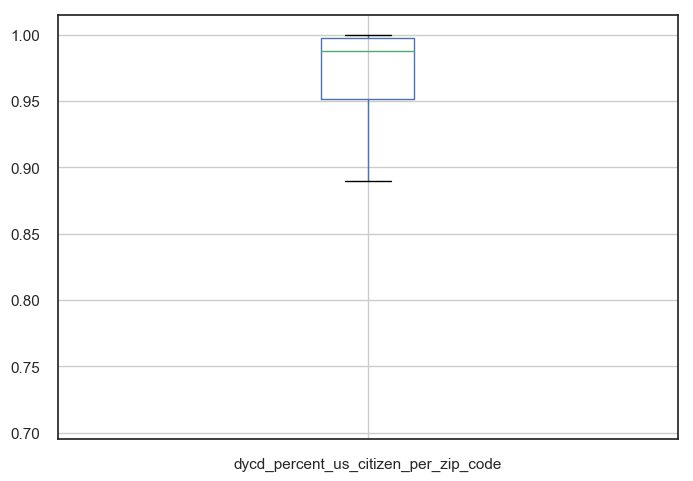

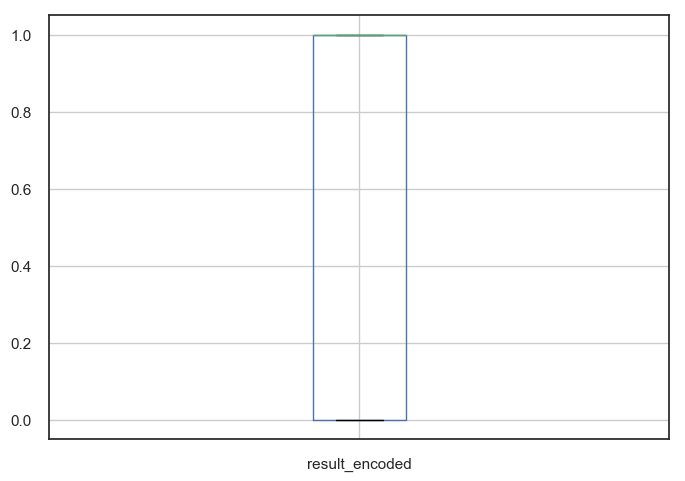

In [70]:
# Create box plots for each numeric column
for i in df.select_dtypes(['float64','int64']).columns.tolist():
    df.boxplot(column=i)
    plt.show();

In [71]:
### Remove outliers based on box plots
df = df[df.mean_property_gfa_self_reported_ft_per_bb < (.2 * 10**7)]
df = df[df.avg_num_dfpv_ids_per_bb < 100]
df = df[df.num_hmcv_per_bbl < 2000]
df = df[df.num_311_complaints_per_bbl < 447]
df = df[df.mean_hpd_feeamount_per_bb < 4000]
df = df[df.dycd_percent_receives_public_assistance_per_zip_code < 0.64]
df = df[df.dycd_percent_male_per_zip_code < 0.8]
df = df[df.dycd_percent_female_per_zip_code < 0.8]
df = df[df.dycd_percent_nreceives_public_assistance_per_zip_code > 0.43]
df = df[df.dycd_percent_us_citizen_per_zip_code > 0.85]
df.shape

### Create dfs for modeling
# feature_cols = df.select_dtypes(['float64','int64']).columns.tolist()
# feature_cols = [x for x in feature_cols if 'result' not in x]
feature_cols = ['bbl',
                'boro_code',
                'block',
                'lot',
                'zip_code',
                'latitude',
                'longitude',
                'bb',
                'num_311_complaints_per_bbl',
                'num_hmcv_per_bbl',
                'mean_property_gfa_self_reported_ft_per_bb',
                'avg_num_dfpv_ids_per_bb',
                'mean_hpd_feeamount_per_bb',
                'dycd_percent_receives_public_assistance_per_zip_code',
                'dycd_percent_male_per_zip_code',
                'dycd_percent_female_per_zip_code',
                'dycd_percent_nreceives_public_assistance_per_zip_code',
                'dycd_percent_us_citizen_per_zip_code']

target = df.result_encoded
features = df[feature_cols]
target.shape
features.shape

# Write to pickle file
df.to_pickle('df_feat.pkl') #use for reset function
df.to_csv('df_feat.csv')

# Read in feat df
# df = pd.read_pickle('df_feat.pkl')


(224931, 28)

(224931,)

(224931, 18)

In [72]:
# Memory Management: delete unused dfs
# del ?

# collect residual garbage
gc.collect()

%whos DataFrame

54006

Variable   Type         Data/Info
---------------------------------
corr       DataFrame                             <...>               1.000000  
df         DataFrame           inspection_type  j<...>224931 rows x 28 columns]
features   DataFrame                   bbl  boro_<...>224931 rows x 18 columns]
gb         DataFrame            boro_code        <...>         5  Staten Island


# Feature Selection

In [73]:
# Create Polynomial and Interactin Terms
poly = PolynomialFeatures(degree=2, include_bias=False)
poly.fit(features)
column_names = poly.get_feature_names(features.columns)
df = pd.DataFrame(poly.transform(features), columns=column_names)

X_train, X_test, y_train, y_test = train_test_split(df, target, random_state=34,test_size=0.2)

# Scale Features
scaler = StandardScaler()
scaler.fit(X_train)
X_train = pd.DataFrame(data=scaler.transform(X_train), columns=column_names)
X_test = pd.DataFrame(data=scaler.transform(X_test), columns=column_names)

PolynomialFeatures(degree=2, include_bias=False, interaction_only=False)

StandardScaler(copy=True, with_mean=True, with_std=True)

### Dummy Classifier for Baseline Assessment

Feature Importance via Random Forests Classifier
Train Accuracy score:  0.5895056239719023
Train F1 score:  0.7417471383320163
Test Accuracy score:  0.5913263831773623
Test F1 score:  0.7431868024417159
True Positives: 26602
True Negatives: 0
False Positives: 18385
False Negatives: 0


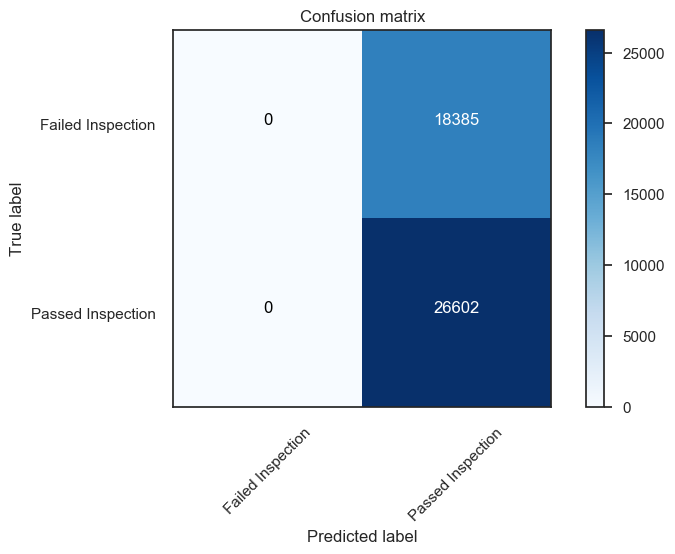

In [74]:
# DummyClassifier to predict target variable 0
with io.capture_output() as captured:
    dummy = DummyClassifier(strategy='most_frequent').fit(X_train, y_train)
    dummy_pred_y_train = dummy.predict(X_train)
    dummy_pred_y_test = dummy.predict(X_test)

# checking accuracy
print('Feature Importance via Random Forests Classifier')
print('Train Accuracy score: ', accuracy_score(y_train, dummy_pred_y_train))
print('Train F1 score: ', f1_score(y_train, dummy_pred_y_train))
print('Test Accuracy score: ', accuracy_score(y_test, dummy_pred_y_test))
print('Test F1 score: ', f1_score(y_test, dummy_pred_y_test))

with io.capture_output() as captured:
    ### Print and Plot Confustion Matrix  ###

    # save confusion matrix and slice into four pieces
    cm = metrics.confusion_matrix(y_test, dummy_pred_y_test)
    classes = ['Failed Inspection', 'Passed Inspection']
    TP = cm[1, 1]
    TN = cm[0, 0]
    FP = cm[0, 1]
    FN = cm[1, 0]

    # Plot confustion matrix
    plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues)

print('True Positives:', TP)
print('True Negatives:', TN)
print('False Positives:', FP)
print('False Negatives:', FN)

In [75]:
# Memory Cleanup

gc.collect()
%whos DataFrame

3116

Variable   Type         Data/Info
---------------------------------
X_test     DataFrame                bbl  boro_cod<...>44987 rows x 189 columns]
X_train    DataFrame                 bbl  boro_co<...>79944 rows x 189 columns]
corr       DataFrame                             <...>               1.000000  
df         DataFrame                     bbl  bor<...>24931 rows x 189 columns]
features   DataFrame                   bbl  boro_<...>224931 rows x 18 columns]
gb         DataFrame            boro_code        <...>         5  Staten Island


## Logistic Regression Classification w/Class Imbalance

Logistic Regression Classification w/Class Imbalance
Train Accuracy score:  0.6225770239630107
Train F1 score:  0.7364090462754169
Test Accuracy score:  0.6218018538688954
Test F1 score:  0.7361597866203516
for Logistic Regression Classification w/Class Imbalance
True Positives: 23736
True Negatives: 4237
False Positives: 14148
False Negatives: 2866


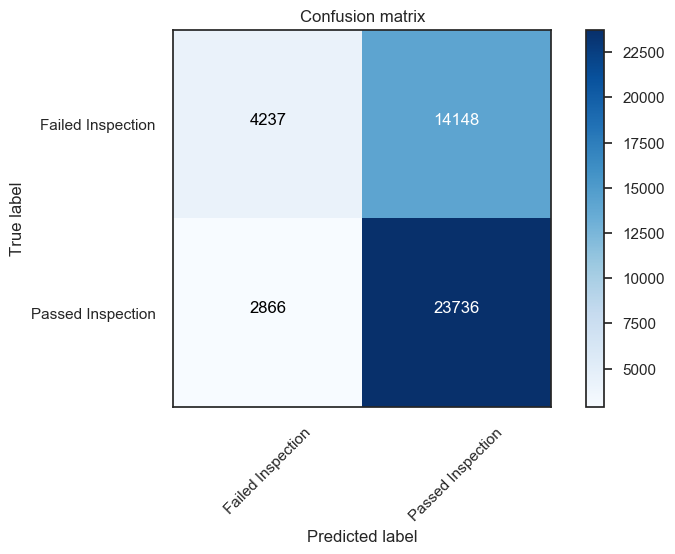

In [76]:
# # Logistic Classifier for Baselining before upsampling
with io.capture_output() as captured:
    lr_clf = LogisticRegression(random_state=34, solver='saga', n_jobs=-1)
    lr_clf.fit(X_train, y_train)
    y_pred_train = lr_clf.predict(X_train)
    y_pred_test = lr_clf.predict(X_test)

# checking accuracy
print('Logistic Regression Classification w/Class Imbalance')
print('Train Accuracy score: ', accuracy_score(y_train, y_pred_train))
print('Train F1 score: ', f1_score(y_train, y_pred_train))
print('Test Accuracy score: ', accuracy_score(y_test, y_pred_test))
print('Test F1 score: ', f1_score(y_test, y_pred_test))

with io.capture_output() as captured:
    ### Print and Plot Confustion Matrix  ###
    # save confusion matrix and slice into four pieces
    cm = metrics.confusion_matrix(y_test, y_pred_test)
    classes = ['Failed Inspection', 'Passed Inspection']
    TP = cm[1, 1]
    TN = cm[0, 0]
    FP = cm[0, 1]
    FN = cm[1, 0]

    # Plot confustion matrix
    plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues)

print('for Logistic Regression Classification w/Class Imbalance')
print('True Positives:', TP)
print('True Negatives:', TN)
print('False Positives:', FP)
print('False Negatives:', FN)

## Rejoining Test set after downsampling

In [77]:
# concatenate our training data back together
with io.capture_output() as captured:
    X_train.reset_index(drop=True,inplace=True)
    y_train.reset_index(drop=True,inplace=True)
    training = pd.concat([X_train, y_train], axis=1)

    # separate minority and majority classes
    failed = training[training.result_encoded==0] # Minority Class
    passed = training[training.result_encoded==1] # Majority Class

    # downsample majority class i.e. passed
    passed_downsampled = resample(passed,
                                  replace=False,  # sample without replacement
                                  n_samples=len(failed),  # match minority n
                                  random_state=34)  # reproducible results
    # combine minority and downsampled majority
    # #  Drop indexes to prevent nans post-concat
    # failed_downsampled.reset_index(drop=True, inplace=True)
    # failed.reset_index(drop=True, inplace=True)

    downsampled = pd.concat([passed_downsampled, failed])

    # Drop duplicate columns should the exist
    downsampled = downsampled.loc[:,~downsampled.columns.duplicated()]

# checking Results
print('Minority and Majority Class Counts Preprocessing: ')
print('Failed Inspection Count: '+ str(len(failed)))
print('Passed Inspection Count: '+ str(len(passed)))

print('Downsampling results: ')
downsampled['result_encoded'].value_counts()

Minority and Majority Class Counts Preprocessing: 
Failed Inspection Count: 73866
Passed Inspection Count: 106078
Downsampling results: 


1    73866
0    73866
Name: result_encoded, dtype: int64

# Logistic Regression Classifier

Logistic Regression Results w/downsampling:/n
Training Accuracy score:  0.5913004630005686
Training F1 score:  0.598336881319851
Test Accuracy score:  0.5927712450263409
Test F1 score:  0.639355880152762
Confustion Matrix for Logistic Regression Classification w/downsampling:/n
True Positives: 16239
True Negatives: 10428
False Positives: 7957
False Negatives: 10363


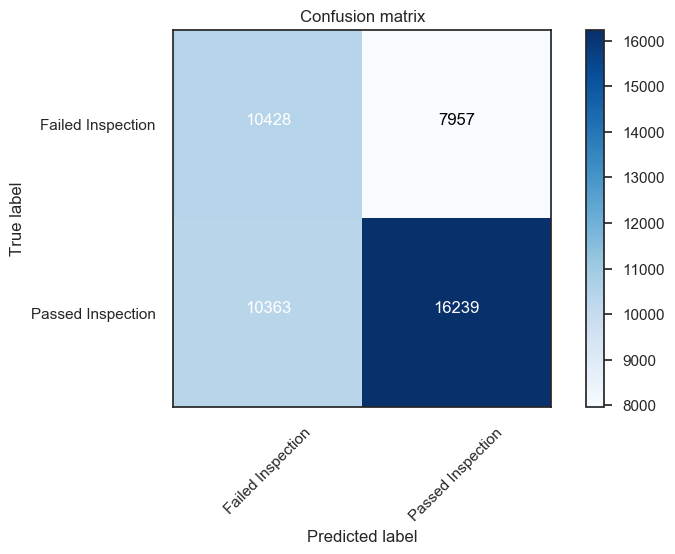

In [78]:
# Plot the classification probability for different classifiers.
# Using a 3 class dataset, and classify it with a Support Vector classifier
# as well as L1 and L2 penalized logistic regression.
with io.capture_output() as captured:
    X_train = downsampled.drop('result_encoded', axis=1)  # independent columns
    y_train = downsampled.result_encoded  # target column i.e price range
    downsampled_lr = LogisticRegression(random_state=34, solver='saga', n_jobs=-1)
    downsampled_lr.fit(X_train, y_train)
    downsampled_pred_y_train = downsampled_lr.predict(X_train)
    downsampled_pred_y_test = downsampled_lr.predict(X_test)
    
    ### Print and Plot Confustion Matrix  ###
    # save confusion matrix and slice into four pieces
    cm = metrics.confusion_matrix(y_test, downsampled_pred_y_test)
    classes = ['Failed Inspection', 'Passed Inspection']
    TP = cm[1, 1]
    TN = cm[0, 0]
    FP = cm[0, 1]
    FN = cm[1, 0]

    # Plot confustion matrix
    plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues)

# checking accuracy
print('Logistic Regression Results w/downsampling:/n')
print('Training Accuracy score: ', accuracy_score(
    y_train, downsampled_pred_y_train))
print('Training F1 score: ', f1_score(y_train, downsampled_pred_y_train))
print('Test Accuracy score: ', accuracy_score(y_test, downsampled_pred_y_test))
print('Test F1 score: ', f1_score(y_test, downsampled_pred_y_test))

print('Confustion Matrix for Logistic Regression Classification w/downsampling:/n')
print('True Positives:', TP)
print('True Negatives:', TN)
print('False Positives:', FP)
print('False Negatives:', FN)



# Feature Importance

### Decision Tree Classifier

Feature Importance via Decision Trees Classifier
Train Accuracy score:  0.6083177646007636
Train F1 score:  0.6040346531265824
Test Accuracy score:  0.6021295040789562
Test F1 score:  0.6383675118698858


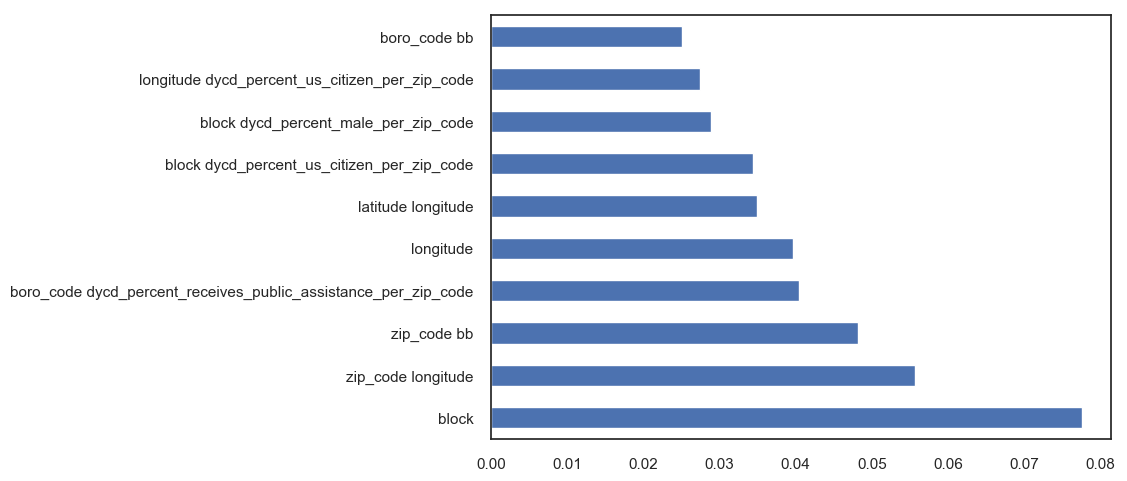

In [79]:
# Plot Feature importance with Tree Based Classifiers inbuilt class
# using Decision Tree Classifier to fit model, predict, and extract the top 10 features
with io.capture_output() as captured:
    X_train = downsampled.drop('result_encoded', axis=1)  #independent columns
    y_train = downsampled.result_encoded   #target column i.e price range
    dt_clf = ExtraTreesClassifier(max_depth=5)
    dt_clf.fit(X_train,y_train)
    dtc_pred_y_train = dt_clf.predict(X_train)
    dtc_pred_y_test = dt_clf.predict(X_test)

# # checking accuracy
print('Feature Importance via Decision Trees Classifier')
print('Train Accuracy score: ', accuracy_score(y_train, dtc_pred_y_train))
print('Train F1 score: ', f1_score(y_train, dtc_pred_y_train))
print('Test Accuracy score: ', accuracy_score(y_test, dtc_pred_y_test))
print('Test F1 score: ', f1_score(y_test, dtc_pred_y_test))

#use inbuilt class feature_importances of tree based classifiers
#plot graph of feature importances for better visualization
feat_importances = pd.Series(dt_clf.feature_importances_, index=X_train.columns)
feat_importances.nlargest(10).plot(kind='barh')
plt.show();

### Random Forest Classifier

Feature Importance via Random Forests Classifier
Train Accuracy score:  0.6054815476673977
Train F1 score:  0.5937759191496776
Test Accuracy score:  0.5948162802587414
Test F1 score:  0.6260769672601953


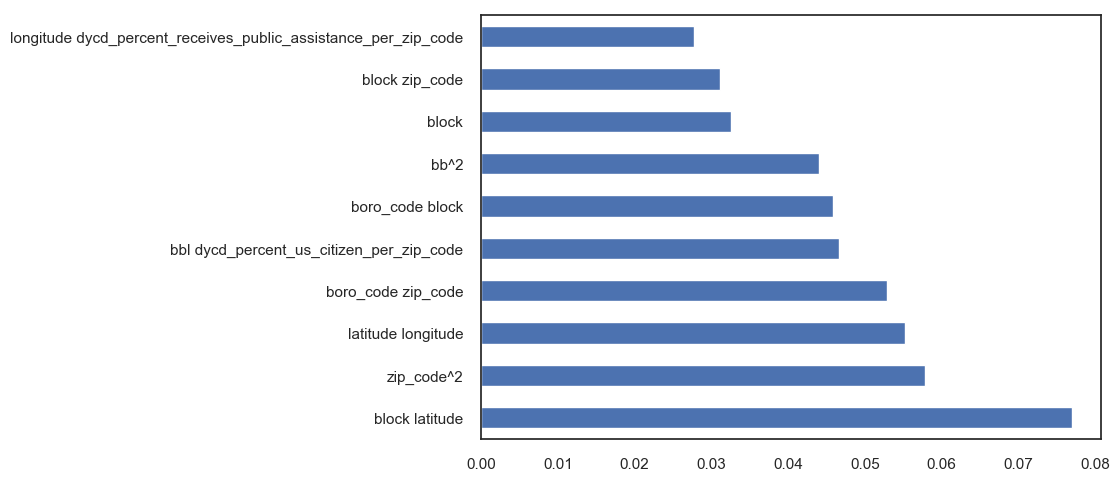

In [80]:
# Plot Feature importance with Tree Based Classifiers inbuilt class
# using Random Forest Classifier to fit model, predict, and extract the top 10 features
with io.capture_output() as captured:
    X_train = downsampled.drop('result_encoded', axis=1)  #independent columns
    y_train = downsampled.result_encoded   #target column i.e price range
    rf_clf = ExtraTreesClassifier(max_depth=5)
    rf_clf.fit(X_train,y_train)
    rfc_pred_y_train = rf_clf.predict(X_train)
    rfc_pred_y_test = rf_clf.predict(X_test)

# # checking accuracy
print('Feature Importance via Random Forests Classifier')
print('Train Accuracy score: ', accuracy_score(y_train, rfc_pred_y_train))
print('Train F1 score: ', f1_score(y_train, rfc_pred_y_train))
print('Test Accuracy score: ', accuracy_score(y_test, rfc_pred_y_test))
print('Test F1 score: ', f1_score(y_test, rfc_pred_y_test))

#use inbuilt class feature_importances of tree based classifiers
#plot graph of feature importances for better visualization
feat_importances = pd.Series(rf_clf.feature_importances_, index=X_train.columns)
feat_importances.nlargest(10).plot(kind='barh')
plt.show();

### Extra Trees Classifier

Feature Importance via Extra Trees Classifier
Train Accuracy score:  0.6026791758048358
Train F1 score:  0.5660014639881106
Test Accuracy score:  0.5813012648098339
Test F1 score:  0.5920117830531971


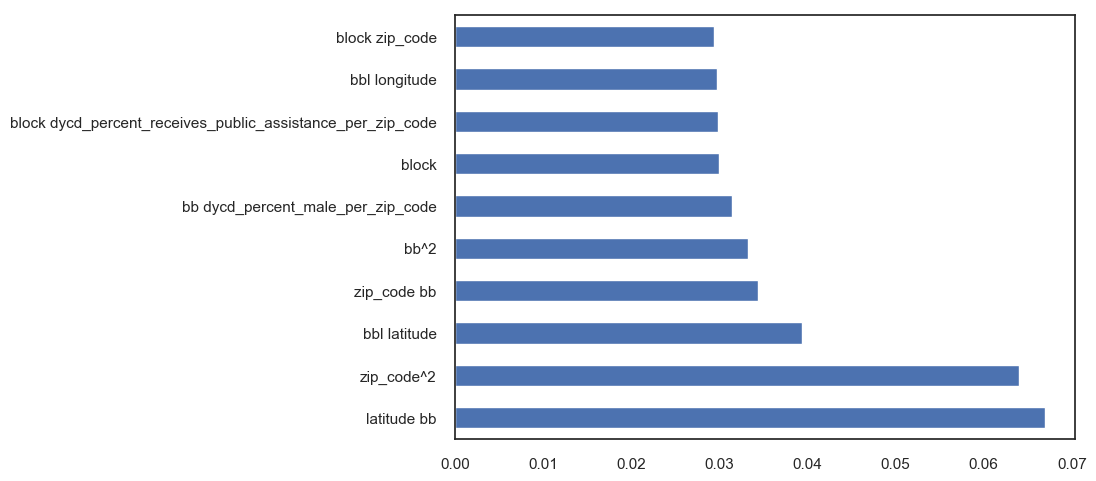

In [81]:
# Plot Feature importance with Tree Based Classifiers inbuilt class
# using Extra Tree Classifier to fit model, predict, and extract the top 10 features
with io.capture_output() as captured:
    X_train = downsampled.drop('result_encoded', axis=1)  #independent columns
    y_train = downsampled.result_encoded   #target column i.e price range
    et_clf = ExtraTreesClassifier(max_depth=5)
    et_clf.fit(X_train,y_train)
    etc_pred_y_train = et_clf.predict(X_train)
    etc_pred_y_test = et_clf.predict(X_test)

# # checking accuracy
print('Feature Importance via Extra Trees Classifier')
print('Train Accuracy score: ', accuracy_score(y_train, etc_pred_y_train))
print('Train F1 score: ', f1_score(y_train, etc_pred_y_train))
print('Test Accuracy score: ', accuracy_score(y_test, etc_pred_y_test))
print('Test F1 score: ', f1_score(y_test, etc_pred_y_test))

#use inbuilt class feature_importances of tree based classifiers
#plot graph of feature importances for better visualization
feat_importances = pd.Series(et_clf.feature_importances_, index=X_train.columns)
feat_importances.nlargest(10).plot(kind='barh')
plt.show();


# Pipeline Setup

In [ ]:
#### Pipeline Creation ####

# Step 1 Logistic Regression
pipe_lr_poly = Pipeline([('poly', PolynomialFeatures(degree=1)),
                         ('scl', StandardScaler()),
                         ('clf', LogisticRegression(random_state=34, n_jobs=-1))])

penalty_param_range = [1.0, 0.5, 0.1, .01]
grid_params_lr = [{'clf__penalty': ['l1'],
                   'clf__C': penalty_param_range, 'clf__solver': ['saga']}]
gs_lr_poly = GridSearchCV(estimator=pipe_lr_poly,
                          param_grid=grid_params_lr, scoring='f1', cv=2)
gs_lr_poly.fit(X_train, y_train)

# Step 2 - DecisionTreeClassifier
penalty_param_range = [1.0, 0.5, 0.1, .01]
grid_params_dt = [{'min_impurity_decrease': [0.0015, 0.002, 0.003], 'criterion':[
    'entropy', 'gini'], 'max_depth': range(6, 10, 1), 'min_samples_leaf': range(1, 8, 1)}]
gs_dt = GridSearchCV(DecisionTreeClassifier(), grid_params_dt)
gs_dt.fit(X_train, y_train)

# Step 3 - KNN
neighbors = list(range(1, 20))
grid_params_KNN = [{'knn__n_neighbors': neighbors,
                    'knn__weights': ['uniform', 'distance']}]
pipe_KNN_poly = Pipeline([('poly', PolynomialFeatures(degree=1)),
                          ('knn', KNeighborsClassifier())])
gs_KNN_poly = GridSearchCV(estimator=pipe_KNN_poly,
                           param_grid=grid_params_KNN,
                           scoring='f1',
                           cv=2)
gs_KNN_poly.fit(X_train, y_train)

# Initialize Pipeline variables
# List of pipelines for ease of iteration
grids = [gs_lr_poly, gs_dt, gs_KNN_poly]

# Dictionary of pipelines and classifier types for ease of reference
grid_dict = {0: 'Logistic Regression', 1: 'Decision Tree',
2: 'KNN'}

/Users/utaveras/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


GridSearchCV(cv=2, error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('poly', PolynomialFeatures(degree=1, include_bias=True, interaction_only=False)), ('scl', StandardScaler(copy=True, with_mean=True, with_std=True)), ('clf', LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn', n_jobs=-1,
          penalty='l2', random_state=34, solver='warn', tol=0.0001,
          verbose=0, warm_start=False))]),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid=[{'clf__penalty': ['l1'], 'clf__C': [1.0, 0.5, 0.1, 0.01], 'clf__solver': ['saga']}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='f1', verbose=0)

/Users/utaveras/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


GridSearchCV(cv='warn', error_score='raise-deprecating',
       estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid=[{'min_impurity_decrease': [0.0015, 0.002, 0.003], 'criterion': ['entropy', 'gini'], 'max_depth': range(6, 10), 'min_samples_leaf': range(1, 8)}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [ ]:
# LogisticRegression Best params
print('LogisticRegression Best params: %s' % gs_lr_poly.best_params_)
# Best training data accuracy
print('LogisticRegression Best training accuracy: %.3f' % gs_lr_poly.best_score_)
# Predict on test data with best params
y_pred = gs_lr_poly.predict(X_test)
# Test data accuracy of model with best params
print('LogisticRegression Test set F1 score for best params: %.3f ' % f1_score(y_test, y_pred))



# DecisionTreeClassifier Best params
print('DecisionTreeClassifier Best params: %s' % gs_dt.best_params_)
# Best training data accuracy
print('DecisionTreeClassifier Best training accuracy: %.3f' % gs_lr.best_score_)
# Predict on test data with best params
y_pred = gs_dt.predict(X_test)
# Test data accuracy of model with best params
print('DecisionTreeClassifier Test set F1 score for best params: %.3f ' % f1_score(y_test, y_pred))



# KNN Best params
print('KNN Best params: %s' % gs_KNN_poly.best_params_)
# Best training data accuracy
print('KNN Best training accuracy: %.3f' % gs_lr_poly.best_score_)
# Predict on test data with best params
y_pred = gs_KNN_poly.predict(X_test)
# Test data accuracy of model with best params
print('KNN Test set F1 score for best params: %.3f ' % f1_score(y_test, y_pred))

# Re-run using ftest score
# Fit the grid search objects
print('Performing model optimizations...')
best_acc = 0.0
best_clf = 0
best_gs = ''
for idx, gs in enumerate(grids):
    print('\nEstimator: %s' % grid_dict[idx])
    # Fit grid search
    gs.fit(X_train, y_train)
    # Best params
    print('Best params: %s' % gs.best_params_)
    # Best training data accuracy
    print('Best training accuracy: %.3f' % gs.best_score_)
    # Predict on test data with best params
    y_pred = gs.predict(X_test)
    # Test data accuracy of model with best params
    print('Test set accuracy score for best params: %.3f ' %
          accuracy_score(y_test, y_pred))
    # Track best (highest test accuracy) model
    if accuracy_score(y_test, y_pred) > best_acc:
        best_acc = accuracy_score(y_test, y_pred)
        best_gs = gs
        best_clf = idx
print('\nClassifier with best test set accuracy: %s' % grid_dict[best_clf])

### Print and Plot Confustion Matrix  ###

# save confusion matrix and slice into four pieces
cm = metrics.confusion_matrix(y_test, y_pred)
classes = ['Failed Inspection', 'Passed Inspection']
TP = cm[1, 1]
TN = cm[0, 0]
FP = cm[0, 1]
FN = cm[1, 0]

# Plot confustion matrix
plot_confusion_matrix(cm, classes,
                      normalize=False,
                      title='Confusion matrix',
                      cmap=plt.cm.Blues)

print('True Positives:', TP)
print('True Negatives:', TN)
print('False Positives:', FP)
print('False Negatives:', FN)


### Code below archived only for reference

In [ ]:
# ### Regularized Logistic Regression ###

# # trying logistic regression again with the balanced dataset
# # Split data to be used in the models
# # Create matrix of features
# reset_data()

# # Create logistic regression
# logistic = linear_model.LogisticRegression(random_state=34, solver='saga', n_jobs=-1)

# # Create regularization penalty space
# penalty = ['l1']

# # Create regularization hyperparameter space
# C = C_param_range = [135, 375, 750]

# # Create hyperparameter options
# hyperparameters = dict(C=C, penalty=penalty)

# # Create grid search using 3-fold cross validation
# lr_clf = GridSearchCV(logistic, hyperparameters, cv=3, scoring='f1', n_jobs=-1) 

# # Fit grid search
# model = lr_clf.fit(X_train, y_train)

# # print(model.feature_importances_)